# DmX Challenge: Predictive Credit Risk Modeling Using Customer Credit Scores and Phone Footprints


In [1]:
# ──────────────────────────────────────────────────────────────────────────
# Script Name : training_etl.py
# Author      : Dilan Castañeda, Paulo Ibarra, Bruno Díaz, Fatima Quintana
# Created On  : Octubre 14, 2024
# Last Update : Octubre 14, 2024
# Version     : 1.0.0
# Description : Credit risk modeling using bureau reports and phone data to predict client default probability.
#──────────────────────────────────────────────────────────────────────────

## Overview

---
Instituto Tecnológico y de Estudios Superiores de Monterrey

Analítica de datos y herramientas de inteligencia artificial TI3001C.103

Profesor: Enrique Ricardo García Hernández

Equipo 2:
*   Dilan González Castañeda             A00831905
*   Fátima Pamela Ramón Quintana         A00833076
*   Paulo Ibarra A01632632
*   Bruno Díaz Flores A0082455


---

**Overview**

Credit risk modeling using bureau reports and phone usage data to predict client default probability for loan approval decisions.

**Database Source**

The database for this project was provided by DMX, containing comprehensive credit bureau reports and detailed phone usage data for each client.

**Key Components**

1. Credit Bureau Data:

* Credit history
* Loan inquiries
* Payment behaviors
* Current debt levels


2. Phone Usage Data:

* Subscription type
* Usage patterns
* Payment history
* Device information


3.  Target Variable:

* Client default status (binary: defaulted or not)



**Project Goals**

Develop a predictive model to assess the likelihood of client loan default
Optimize loan approval decisions based on calculated risk
Enhance the overall loan portfolio quality by minimizing potential defaults

**Methodology**

* Utilize machine learning techniques to analyze historical data
* Incorporate both traditional credit metrics and alternative data (phone usage)
* Create a robust model that can handle various data types and complex relationships

**Expected Outcome**
A reliable credit risk assessment tool that can:

* Accurately predict client default probability
* Assist in making informed loan approval decisions
* Potentially increase approval rates for creditworthy clients while minimizing risk

This project aims to leverage the unique combination of traditional credit data and alternative phone usage data provided by DMX to create a more comprehensive and accurate credit risk assessment model.

### 1. ETL for Model Training

#### Purpose
- Prepare historical data for model development and training.

#### Process
1. **Extract**:
   - Pull historical data from DMX database (credit bureau reports and phone usage data).
   - Include all available features and the target variable (default status).

2. **Transform**:
   - Handle missing values, outliers, and data quality issues.
   - Perform feature engineering (e.g., creating interaction terms, deriving new features).
   - Encode categorical variables.
   - Normalize or standardize numerical features.

3. **Load**:
   - Store the processed data in a format suitable for model training (e.g., parquet files, a data warehouse).

#### Benefits
- Can perform extensive data cleaning and feature engineering.
- Allows for complex transformations that might be computationally expensive.
- Can use the full historical dataset for better feature creation and selection.

By implementing separate ETL processes for training and scoring, we can optimize our credit risk model for both comprehensive learning from historical data and efficient, consistent scoring of new records.

## ETL

### Extract

In [2]:
%pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from pandas import DataFrame
from typing import Dict, List
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import pydotplus
from six import StringIO
from IPython.display import Image

In [4]:
# Define the path to the file
# Using the file inside the repository
file_name = r'C:\Users\dilan\Documents\Github\DataAnalysis_and_AI\period_2\Resources\Challenge\base_Reto.csv'

# Using the file from the repository
url = 'https://raw.githubusercontent.com/magotronico/DataAnalysis_and_AI/main/period_2/Resources/Challenge/base_Reto.csv'

# Load original DataBase (csv)
df = pd.read_csv(url, encoding='latin-1')

In [5]:
# New information about the dataframe function to get more information about the columns
def info_df(df):
    """
    This function returns a dataframe with the following information for each column:
    - Column name
    - Data type
    - Number of unique values
    - Number of NaN values
    - Number of non-NaN values
    """

    print(f'The dataframe has {df.shape[1]} columns and {df.shape[0]} rows')
    print(f'dtype: object({df.select_dtypes(include="object").shape[1]}), int64({df.select_dtypes(include="int64").shape[1]}), float64({df.select_dtypes(include="float64").shape[1]})')

    temp_df = pd.DataFrame(columns=['Column', 'dtype', 'Unique Values', 'nan', 'size'])
    
    for column in df.columns:
        unique_values = [df[column].unique()]  # Ensure unique values are in a list
        temp_df = pd.concat([temp_df, pd.DataFrame({'Column': [column], 'dtype': [df[column].dtype], 'Unique Values': unique_values})], ignore_index=True)
        temp_df.loc[temp_df['Column'] == column, 'nan'] = df[column].isnull().sum()
        temp_df.loc[temp_df['Column'] == column, 'size'] = df[column].count()
    
    return temp_df

info_df(df)

The dataframe has 41 columns and 25101 rows
dtype: object(2), int64(36), float64(3)


,Column,dtype,Unique Values,nan,size
0,Solicitud_id,float64,"[1993059.0, 1993154.0, 1993230.0, 1993287.0, 1...",0,25101
1,Aprobado,int64,"[1, 0]",0,25101
2,Hit_Buro_Huella,int64,"[11, 10, 1, 0]",0,25101
3,Malo,int64,"[0, 1, -1]",0,25101
4,Num_IQ_U3M_PL_Financieras,int64,"[0, 1, 4, 2, -1, 3, 6, -2, 5, 7, 8, 10, 9, 18]",0,25101
5,Edad_cliente,int64,"[61, 67, 68, 64, 54, 63, 77, 40, 47, 72, 73, 4...",0,25101
6,Porcentaje_cuentas_abiertas,float64,"[0.3, 0.333333333, 0.073170732, 0.75, 0.147286...",0,25101
7,Num_IQ_U3M,int64,"[1, 3, 7, 12, 6, 5, 8, 4, 10, 18, 11, -1, 2, 0...",0,25101
8,Num_IQ_U3M_TDC_Banco,int64,"[0, 1, 2, -1, 5, 4, 3, -2, 6, 7]",0,25101
9,MaxMOP_U3M,int64,"[2, 9, 1, 7, -1, 0, 6, 3, 4, 5]",0,25101


### Transform


In [6]:
# Classify the columns in the dataframe to build the scorecard
extra = [
    'aprobado',
    'malo',
    'hit_group'
]

demografica = [
    'edad_cliente',
    'entidad_federativa',
    'ingreso_bruto'
]

buro = [
    'num_iq_u3m_pl_financieras',
    'porcentaje_cuentas_abiertas',
    'num_iq_u3m',
    'num_iq_u3m_tdc_banco',
    'maxmop_u3m',
    'saldo_actual_prest_personales',
    'num_iq_u3m_prest_personales',
    'numero_ctas_atraso_prest_personales_u3m',
    'numero_ctas_atraso_tdc_u3m',
    'ctas_ab_u18m_tdc_banco',
    'num_ctas_prest_pers',
    'flag_prest_nomina',
    'meses_cta_mas_antig',
    'flag_fraude_prest_nomina',
    'flag_fraude_hipotecario',
    'flag_quebranto_prest_personal'
]

huella = [
    'tipo_suscripcion',
    'tipo_suscripcion_POSPAGO',
    'tipo_suscripcion_PREPAGO',
    'status',
    'antiguedad_uso_linea_celular',
    'gasto_mensual_telefonia',
    'actividad_usuario',
    'cambio_sim_u3m',
    'variable_37',
    'gasto_ultimos_60_dias',
    'score_fpd',
    'rango_dispositivo',
    'adopcion_tecno',
    'score_incumplimiento',
    'tasa_contactacion',
    'calidad_telefonica',
    'score_contactabilidad_entrante',
    'score_contactabilidad_saliente',
    'disciplina_tech',
    'cluster_sucursales'
]

In [7]:
class DataPreprocessor:
    def __init__(self, df):
        # Store the original DataFrame
        self.df = df.copy(deep=True) # Avoid modifying the original DataFrame
        self.pre_transformation()

    def pre_transformation(self):
        """
        This method performs the following operations:
        - Standardize column names
        - Replace 'contabilidad' with 'contactabilidad' in column name
        - Drop 'solicitud_id' column
        - Replace certain 'entidad_federativa' values with standardized names
        - Handle invalid 'tipo_suscripcion' values
        - Categories 'entidad_federativa' into groups based on morosidad rate
        """
        # Standardize column names
        self.df.columns = [unidecode(col).lower() for col in self.df.columns]
        # Replace 'contabilidad' with 'contactabilidad' in column name
        self.df.columns = self.df.columns.str.replace('contabilidad', 'contactabilidad')
        # Drop 'solicitud_id' column
        self.df.drop(columns=['solicitud_id'], inplace=True)
        # Replace certain 'entidad_federativa' values with standardized names
        self.replace_entidades()
        # Handle invalid 'tipo_suscripcion' values
        self.handle_invalid_suscripcion()

    def replace_entidades(self):
        """
        Replaces certain 'entidad_federativa' values with standardized names.
        """
        replacements = {
            'CDM': 'CDMX',
            'MIC': 'MICH',
            'QR': 'QRO',
            'TLA': 'TLAX'
        }
        
        self.df['entidad_federativa'] = self.df['entidad_federativa'].replace(replacements)
        # fill NaN values with most common value
        self.df['entidad_federativa'] = self.df['entidad_federativa'].fillna(self.df['entidad_federativa'].mode()[0])

    def handle_invalid_suscripcion(self):
        """
        Replaces invalid values in 'tipo_suscripcion' with NaN.
        """
        self.df['tipo_suscripcion'] = self.df['tipo_suscripcion'].apply(lambda x: x if x in ['PREPAGO', 'MIXTO', 'POSPAGO'] else np.nan)

    def transform_new_record(self, new_record):
        """
        Transforms new data by applying all saved transformations.
        """
        new_df = pd.DataFrame([new_record], columns=self.columns)

        # Apply stored transformations
        new_df.columns = [unidecode(col).lower() for col in new_df.columns]
        new_df.columns = new_df.columns.str.replace('contabilidad', 'contactabilidad')
        new_df.drop(columns=self.columns_to_drop, inplace=True, errors='ignore')
        new_df['entidad_federativa'] = new_df['entidad_federativa'].replace({
            'CDM': 'CDMX',
            'MIC': 'MICH',
            'QR': 'QRO',
            'TLA': 'TLAX'
        })
        new_df['tipo_suscripcion'] = new_df['tipo_suscripcion'].apply(lambda x: x if x in ['PREPAGO', 'MIXTO', 'POSPAGO'] else np.nan)
        new_df['hit_buro_huella'] = new_df['hit_buro_huella'].map({0: 1, 1: 1, 10: 2, 11: 3})

        # Apply entity grouping transformation
        new_df['grupo'] = new_df['entidad_federativa'].apply(self.assign_group)
        
        return new_df
    
    def create_scorecards(self):
        """
        Creates scorecards for each 'hit_buro_huella' group.
        """
        # Split 'hit_buro_huella' values into different scorecards
        self.df['hit_buro_huella'] = self.df['hit_buro_huella'].map({0: 1, 1: 1, 10: 2, 11: 3})

        # Create scorecards
        self.scorecard_1 = self.df[self.df['hit_buro_huella'] == 1].copy(deep=True)
        self.scorecard_2 = self.df[self.df['hit_buro_huella'] == 2].copy(deep=True)
        self.scorecard_3 = self.df[self.df['hit_buro_huella'] == 3].copy(deep=True)

        # Define the columns for each scorecard
        scorecard_1_cols = extra + demografica + huella
        scorecard_2_cols = extra + demografica + buro
        scorecard_3_cols = extra + demografica + buro + huella

        # Function to keep only specified columns in a dataframe
        def keep_columns(df, columns_to_keep):
            return df[df.columns.intersection(columns_to_keep)]

        # Modify each scorecard dataframe
        self.scorecard_1 = keep_columns(self.scorecard_1, scorecard_1_cols)
        self.scorecard_2 = keep_columns(self.scorecard_2, scorecard_2_cols)
        self.scorecard_3 = keep_columns(self.scorecard_3, scorecard_3_cols)

        # Print the number of columns in each scorecard for verification
        print(f"Scorecard 1 (Demographic and footprint): {self.scorecard_1.shape[1]} columns and {self.scorecard_1.shape[0]} rows")
        print(f"Scorecard 2 (Demographic and credit): {self.scorecard_2.shape[1]} columns and {self.scorecard_2.shape[0]} rows")
        print(f"Scorecard 3 (Demographic, footprint and credit): {self.scorecard_3.shape[1]} columns and {self.scorecard_3.shape[0]} rows")

        return self.scorecard_1, self.scorecard_2, self.scorecard_3

# Create an instance of the DataTransformer class
dp = DataPreprocessor(df)
scorecard_1, scorecard_2, scorecard_3 = dp.create_scorecards()

Scorecard 1 (Demographic and footprint): 23 columns and 3325 rows
Scorecard 2 (Demographic and credit): 21 columns and 6691 rows
Scorecard 3 (Demographic, footprint and credit): 39 columns and 15085 rows


In [8]:
class DataTransformer:
    def __init__(self, df, val_threshold=11, tail_threshold=0.05, bin_min=0.05, bin_max=0.35, bin_size=0.2):
        # Store the original DataFrame
        self.df = df.copy(deep=True) # Avoid modifying the original DataFrame
        self.val_threshold = val_threshold
        self.tail_threshold = tail_threshold
        self.bin_min = bin_min
        self.bin_max = bin_max
        self.bin_size = bin_size
        self.ordinal_encoders = {} # Store binning information
        self.outlier_thresholds = {}  # Store thresholds for outliers from x_train
        self.grupos_porcentuales = {} # Store 'entidad_federativa' groups
        self.one_hot_encoder = None
        self.group_dict_entidad_federativa()

    def group_dict_entidad_federativa(self, malo_column='malo', entidad_column='entidad_federativa', num_groups=5):
        """
        Groups 'entidad_federativa' by their morosidad rate and assigns each to a group.
        """
        
        # Calculate morosidad rate and percentage of information for each 'entidad_federativa'
        tasa_morosidad_por_entidad = self.df.groupby(entidad_column)[malo_column].apply(lambda x: x.sum() / x.count()).reset_index(name='tasa_morosidad')
        porcentaje_informacion_por_entidad = self.df[entidad_column].value_counts(normalize=True).reset_index(name='porcentaje_informacion')
        porcentaje_informacion_por_entidad.rename(columns={'index': entidad_column}, inplace=True)
        
        # Combine the two tables and sort by 'tasa_morosidad'
        tabla_combinada = pd.merge(tasa_morosidad_por_entidad, porcentaje_informacion_por_entidad, on=entidad_column)
        tabla_combinada = tabla_combinada.sort_values(by='tasa_morosidad', ascending=True)

        # Assign each 'entidad_federativa' to a group
        tamano_grupo = 1 / num_groups
        porcentaje_acumulado = 0
        grupo_actual = 1
        tabla_combinada['grupo'] = 0

        for index, row in tabla_combinada.iterrows():
            porcentaje_acumulado += row['porcentaje_informacion']
            tabla_combinada.at[index, 'grupo'] = grupo_actual
            if porcentaje_acumulado >= tamano_grupo:
                grupo_actual += 1
                porcentaje_acumulado = 0

        # Create a flat dictionary with 'entidad_federativa' as key and its group as value
        self.grupos_porcentuales = dict(zip(tabla_combinada[entidad_column], tabla_combinada['grupo']))

        return self.grupos_porcentuales

    def process_entidad_federativa(self, x):
        """
        Assigns a state to its group based on the processed 'entidad_federativa'.
        """
        # Use apply with a lambda function for quick dictionary lookup
        x['entidad_federativa'] = x['entidad_federativa'].apply(lambda estado: self.grupos_porcentuales.get(estado, 7))
        
        return x

    def outlier_correction(self, val_threshold=11, tail_threshold=0.05):
        """
        Corrects outliers for numeric variables.
        """
        x_copy = self.df.copy(deep=True)
        for column in x_copy.columns:
            if x_copy[column].dtype in ['int64', 'float64']:
                if x_copy[column].nunique() > val_threshold:
                    q1 = x_copy[x_copy[column] > 0][column].quantile(tail_threshold)
                    q3 = x_copy[x_copy[column] > 0][column].quantile(1 - tail_threshold)
                    x_copy[column] = x_copy[column].apply(lambda x: q3 if x > q3 else q1 if x < q1 else x)
                    self.outlier_thresholds[column] = (q1, q3)

        self.df = x_copy

    def outlier_correction_test(self, df):
        for col, (lower_bound, upper_bound) in self.outlier_thresholds.items():
            if col in df.columns:
                df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
                df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
            else:
                continue
        return df
    
    def process_edad_ingreso(self):
        """
        Bins 'edad_cliente' and 'ingreso_bruto' columns.
        """
        x_copy = self.df.copy(deep=True)

        for column in ['edad_cliente', 'ingreso_bruto']:
            if x_copy[column].dtype in ['int64', 'float64'] and x_copy[column].nunique() > self.val_threshold:
                bin_0 = x_copy[x_copy[column] < 0]  # Bin for negative values
                bin_1 = x_copy[x_copy[column] >= 0]  # df for positive values

                if bin_0.empty:  # Only positive values
                    bins, bin_labels = pd.qcut(bin_1[column], q=5, labels=False, retbins=True, duplicates="drop")
                    interval_labels = [f"({bin_labels[i]:.2f} - {bin_labels[i+1]:.2f})" for i in range(len(bin_labels)-1)]
                    bin_1[column] = pd.cut(bin_1[column], bins=bin_labels, labels=interval_labels, include_lowest=True)

                    self.df[column] = bin_1[column]

                elif bin_0.shape[0] < self.bin_min * x_copy.shape[0]:  # Merge bin_0 if <5% data
                    TdM_0 = bin_0['malo'].mean() if 'malo' in bin_0.columns else None
                    TdM_1 = bin_1.groupby(column)['malo'].mean().to_dict() if 'malo' in bin_1.columns else {}

                    if TdM_0 is not None and TdM_1:
                        distances = {k: abs(v - TdM_0) for k, v in TdM_1.items()}
                        closest_bin = min(distances, key=distances.get)
                        bin_0[column] = closest_bin

                    self.df[column] = pd.concat([bin_0[column], bin_1[column]], axis=0)

                elif bin_0.shape[0] >= self.bin_min * x_copy.shape[0]:  # Bin negative values separately
                    bins_pos, bin_labels_pos = pd.qcut(bin_1[column], q=5, labels=False, retbins=True, duplicates="drop")
                    interval_labels_pos = [f"({bin_labels_pos[i]:.2f} - {bin_labels_pos[i+1]:.2f})" for i in range(len(bin_labels_pos)-1)]
                    bin_1[column] = pd.cut(bin_1[column], bins=bin_labels_pos, labels=interval_labels_pos, include_lowest=True)

                    bins_neg, bin_labels_neg = pd.qcut(bin_0[column], q=2, labels=False, retbins=True, duplicates="drop")
                    interval_labels_neg = [f"({bin_labels_neg[i]:.2f} - {bin_labels_neg[i+1]:.2f})" for i in range(len(bin_labels_neg)-1)]
                    bin_0[column] = pd.cut(bin_0[column], bins=bin_labels_neg, labels=interval_labels_neg, include_lowest=True)

                    self.df[column] = pd.concat([bin_0[column], bin_1[column]], axis=0)

                # Apply ordinal encoding after binning
                ordinal_encoder = OrdinalEncoder()
                self.df[column] = ordinal_encoder.fit_transform(self.df[[column]])
                self.ordinal_encoders[column] = ordinal_encoder
    
    def process_tipo_suscripcion(self):
        """
        One-hot encodes 'tipo_suscripcion'.
        """
        self.df['tipo_suscripcion_POSPAGO'] = self.df['tipo_suscripcion'].apply(lambda x: 1 if x == 'POSPAGO' else 0)
        self.df['tipo_suscripcion_PREPAGO'] = self.df['tipo_suscripcion'].apply(lambda x: 1 if x == 'PREPAGO' else 0)
        self.df = self.df.drop(columns=['tipo_suscripcion'])
        
    def return_df(self):
        self.outlier_correction(self.val_threshold, self.tail_threshold)
        self.df = self.process_entidad_federativa(x=self.df) # Create 'entidad_federativa' groups
        self.process_edad_ingreso()    # Binning
        if 'tipo_suscripcion' in self.df.columns:
            self.process_tipo_suscripcion() # One hot encoding

        # For further analysis, the follwing line should be uncommented
        # self.binning_columns()

        return self.df



# Create an instance of the DataTransformer class
scorecards_transformers = {}
binning_scorecards = {}

for i, scorecard in enumerate([scorecard_1, scorecard_2, scorecard_3]):
    dt = DataTransformer(scorecard)
    scorecards_transformers[f'scorecard_{i+1}'] = dt
    binning_scorecards[f'scorecard_{i+1}'] = dt.return_df()

## Training Models

### Split raw database

* 75% train - 25% test

In [9]:
scorecards = ['scorecard_1', 'scorecard_2', 'scorecard_3']

# Initialize dictionaries to store train/test sets for each scorecard
x_train_dict = {}
x_test_dict = {}
y_train_dict = {}
y_test_dict = {}

# Loop over each scorecard
for sc in scorecards:
    # Filter the scorecard data based on 'aprobado' being 1
    temp = binning_scorecards[sc][(binning_scorecards[sc]['aprobado'] == 1)]
    
    # Define target 'y' and features 'x'
    y = temp['malo']
    x = temp.drop(columns=['aprobado'])  # Drop 'aprobado' but keep 'malo' for calculations
    
    # Split the dataset into training and test sets (75% training, 25% test)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    
    # Store the train/test splits in the dictionaries
    x_train_dict[sc] = x_train
    x_test_dict[sc] = x_test
    y_train_dict[sc] = y_train
    y_test_dict[sc] = y_test


### x_train treatment

#### Bin creation

In [10]:
def bin_creation(x: DataFrame, max: float = 0.35, bin_size = 0.2, min: float = 0.05, val_threshold: int = 11) -> DataFrame:
    """
    This function creates bins for the numeric variables in the dataframe. It uses the TdM to merge bin of values <0 to bin with similar TdM if it is less than 5% of the total data.

    **Parameters**
    x: *DataFrame* Dataframe to be binned.
    max: *float* [default = 0.35] Maximum value for the bin size.
    bin_size: *float* [default = 0.2] Size of the bins.
    min: *float* [default = 0.05] Minimum value for the bin size.
    val_threshold: *int* [default = 10] Amount of unique values before considered a variable categorical.

    **Returns**
    x_copy: *DataFrame* Dataframe with the bins created.
    """


    # Copy the dataframe to avoid modifying the original
    x_copy = x.copy(deep=True)
    x_output = pd.DataFrame()

    # Loop through all columns to create bins
    for column in x_copy.columns:

        # Check if the column is numeric
        if x_copy[column].dtype in ['int64', 'float64'] and x_copy[column].nunique() > val_threshold:
            # print(f"Processing column {column}")
            bin_0 = x_copy[x_copy[column] < 0] # Bin for negative values
            bin_1 = x_copy[(x_copy[column] >= 0)] # df for positive values

            # Check if bin_0 is empty
            if bin_0.shape[0] == 0:
                # Create 5 bins with 20% percentiles for positive values
                bins, bin_labels = pd.qcut(bin_1[column], q=5, labels=False, retbins=True, duplicates="drop")

                # Create tags for the bins
                interval_labels = [f"({bin_labels[i]:.2f} - {bin_labels[i+1]:.2f})" for i in range(len(bin_labels)-1)]

                # Assign tag values with intervals, with no limits duplicated
                bin_1[column] = pd.cut(bin_1[column], bins=bin_labels, labels=interval_labels, right=False)

                x_output[column] = bin_1[column]
                x_output[column] = x_output[column].astype(str)

                # Label encode the bins
                ordinal_encoder = OrdinalEncoder()
                x_output[column] = ordinal_encoder.fit_transform(x_output[[column]])
                x_output[column] = x_output[column].astype(int)

            # Check if bin_0 is less than 5% of the total if so, merge it with the bin of positive values with similar TdM
            elif bin_0.shape[0] < min * x_copy.shape[0]:
                # print(f"Column {column} has less than {min * 100}% of the data in the negative bin")
                # Create 5 bins with 20% percentiles for positive values
                bins, bin_labels = pd.qcut(bin_1[column], q=5, labels=False, retbins=True, duplicates="drop")

                # Create tags for the bins
                interval_labels = [f"({bin_labels[i]:.2f} - {bin_labels[i+1]:.2f})" for i in range(len(bin_labels)-1)]

                # Assign tag values with intervals, with no limits duplicated
                bin_1[column] = pd.cut(bin_1[column], bins=bin_labels, labels=interval_labels, right=False)

                # Calculate the TdM for each bin
                TdM_0 = bin_0['malo'].mean() if not bin_0.empty else None
                TdM_1 = bin_1.groupby(column, observed=False)['malo'].mean().to_dict()

                # If TdM_0 is None, skip further processing for this column
                if TdM_0 is None:
                    continue

                # Add bin_0 to the bin from bin_1 with the most similar TdM
                distances = {k: abs(v - TdM_0) for k, v in TdM_1.items()}
                min_distance = 99999
                for key, value in distances.items():
                    if value < min_distance:
                        min_distance = value
                        closest_bin = key

                # Assign the bin label to the value
                bin_0[column] = closest_bin
                x_output[column] = pd.concat([bin_0[column], bin_1[column]], axis=0)

                # Ensure the column is formatted as string
                x_output[column] = x_output[column].astype(str)

                # Label encode the bins
                ordinal_encoder = OrdinalEncoder()
                x_output[column] = ordinal_encoder.fit_transform(x_output[[column]])
                x_output[column] = x_output[column].astype(int)

            # Check if bin_0 is more than 5% of the total if so, create bins for both positive and negative values
            elif bin_0.shape[0] > min * x_copy.shape[0]:
                # print(f"Column {column} has been binned with {len(x_output[column].unique())} bins")
                # Create 5 bins with 20% percentiles for positive values
                bins, bin_labels = pd.qcut(bin_1[column], q=5, labels=False, retbins=True, duplicates="drop")

                # Create tags for the bins
                interval_labels = [f"({bin_labels[i]:.2f} - {bin_labels[i+1]:.2f})" for i in range(len(bin_labels)-1)]

                # Assign tag values with intervals, with no limits duplicated
                bin_1[column] = pd.cut(bin_1[column], bins=bin_labels, labels=interval_labels, right=False)

                bin_0_bins, bin_0_labels = pd.qcut(bin_0[column], q=1, labels=False, retbins=True, duplicates="drop")
                bin_0_interval_labels = [f"({bin_0_labels[i]:.2f} - {bin_0_labels[i+1]:.2f})" for i in range(len(bin_0_labels)-1)]
                bin_0[column] = pd.cut(bin_0[column], bins=bin_0_labels, labels=bin_0_interval_labels, right=False)

                x_output[column] = pd.concat([bin_0[column], bin_1[column]], axis=0)
                x_output[column] = x_output[column].astype(str)

                # Label encode the bins
                ordinal_encoder = OrdinalEncoder()
                x_output[column] = ordinal_encoder.fit_transform(x_output[[column]])
                x_output[column] = x_output[column].astype(int)

        # If the column has only 2 unique values, it is considered binary
        elif x_copy[column].nunique() == 2:
                x_output[column] = x_copy[column]
                x_output[column] = x_output[column].astype(int)

        # For categorical variables that are already label encoded
        elif x_copy[column].dtype in ['int64', 'float64'] and x_copy[column].nunique() <= val_threshold:
            # Create bins with 20% percentiles
            bins, bin_labels = pd.qcut(x_copy[column], q=5, labels=False, retbins=True, duplicates="drop")

            # Create tags for the bins
            interval_labels = [f"({bin_labels[i]:.2f} - {bin_labels[i+1]:.2f})" for i in range(len(bin_labels)-1)]

            # Assign tag values with intervals, with no limits duplicated
            x_copy[column] = pd.cut(x_copy[column], bins=bin_labels, labels=interval_labels, right=False)

            while True:
                # Get bin counts as a percentage of total
                bin_counts = x_copy[column].value_counts(normalize=True)

                # Identify bins below the threshold
                small_bins = bin_counts[bin_counts < min].index

                # If there are no bins smaller than the threshold, exit the loop
                if len(small_bins) == 0:
                    break

                for small_bin in small_bins:
                    bin_index = interval_labels.index(small_bin)

                    if bin_index == 0:
                        # Merge with the next bin if it's the first bin
                        next_bin = interval_labels[bin_index + 1]
                        x_copy[column] = x_copy[column].replace(small_bin, next_bin)

                    elif bin_index == len(interval_labels) - 1:
                        # Merge with the previous bin if it's the last bin
                        prev_bin = interval_labels[bin_index - 1]
                        x_copy[column] = x_copy[column].replace(small_bin, prev_bin)

                    else:
                        # Merge with the nearest bin with more than 5% of the data
                        prev_bin = interval_labels[bin_index - 1]
                        next_bin = interval_labels[bin_index + 1]

                        # Choose the bin with more than 5%, or the larger bin if both are <5%
                        if bin_counts[prev_bin] >= bin_counts[next_bin]:
                            x_copy[column] = x_copy[column].replace(small_bin, prev_bin)
                        else:
                            x_copy[column] = x_copy[column].replace(small_bin, next_bin)

                # Update interval labels after merging
                interval_labels = x_copy[column].unique()

            # Label encode the bins
            x_output[column] = x_copy[column].astype(str)
            ordinal_encoder = OrdinalEncoder()
            x_output[column] = ordinal_encoder.fit_transform(x_output[[column]])
            x_output[column] = x_output[column].astype(int)

        else:
            if column == 'entidad_federativa':
                x_output[column] = x_output[column].astype(int)
            elif column == 'tipo_suscripcion':
                x_output[column] = x_copy[column].astype(int)
            # print(f"Column {column} is not numeric ({x_copy[column].dtype}) or has less than {val_threshold} unique values ({x_copy[column].nunique()})")

    return x_output

def merge_low_freq_labels(df, threshold=0.05):
    # For each column in the dataframe
    for col in df.columns:
        # Get the frequency distribution of the column
        freq = df[col].value_counts(normalize=True)

        # Identify labels with a frequency below the threshold
        low_freq_labels = freq[freq < threshold].index

        # Replace each low-frequency label
        for label in low_freq_labels:
            # Get sorted unique values of the column
            unique_vals = sorted(df[col].unique())
            # Find index of the low-frequency label in the unique values
            idx = unique_vals.index(label)

            # Find the nearest label: if possible, use the previous or next value
            if idx == 0:  # If the label is the first one, use the next
                nearest_label = unique_vals[idx + 1]
            elif idx == len(unique_vals) - 1:  # If the label is the last one, use the previous
                nearest_label = unique_vals[idx - 1]
            else:
                # Compare the distance between the previous and next labels
                prev_label = unique_vals[idx - 1]
                next_label = unique_vals[idx + 1]

                # Assign to the closest label
                nearest_label = prev_label if abs(prev_label - label) <= abs(next_label - label) else next_label

            # Replace low frequency label with the nearest label
            df[col].replace(label, nearest_label, inplace=True)

    return df

def process_train_sets(train_dict: dict) -> dict:
    """
    This function applies the bin_creation and merge_low_freq_labels functions to each x_train
    dataset in the dictionary and returns a dictionary with processed datasets.

    **Parameters**
    train_dict: *dict* Dictionary containing the x_train datasets.

    **Returns**
    processed_dict: *dict* Dictionary containing the processed x_train datasets.
    """
    processed_dict = {}

    for key, x_train in train_dict.items():
        print(f"Processing {key}...")
        # Apply the bin_creation function
        x_train_bins = bin_creation(x_train)
        
        # Apply the merge_low_freq_labels function
        x_train_bins = merge_low_freq_labels(x_train_bins)
        
        # Store the processed dataset in the dictionary
        processed_dict[key] = x_train_bins

    return processed_dict

def process_test_sets(test_dict: dict, train_dict: dict) -> dict:
    """
    This function applies the bin_creation and merge_low_freq_labels functions to each x_test
    dataset in the dictionary using the thresholds from the corresponding x_train dataset, and
    returns a dictionary with processed datasets.

    **Parameters**
    test_dict: *dict* Dictionary containing the x_test datasets.
    train_dict: *dict* Dictionary containing the x_train datasets.

    **Returns**
    processed_dict: *dict* Dictionary containing the processed x_test datasets.
    """
    processed_dict = {}

    for key, x_test in test_dict.items():
        print(f"Processing {key}...")
        # Apply the bin_creation function using the thresholds from the corresponding x_train dataset
        x_test_bins = bin_creation(x_test, max=0.35, bin_size=0.2, min=0.05, val_threshold=11)
        
        # Apply the merge_low_freq_labels function
        x_test_bins = merge_low_freq_labels(x_test_bins)
        
        # Store the processed dataset in the dictionary
        processed_dict[key] = x_test_bins
    
    return processed_dict

In [11]:
# Process the training sets for each scorecard binned
processed_train_dict = process_train_sets(x_train_dict)

# Process the test sets for each scorecard binned
processed_test_dict = process_test_sets(x_test_dict, processed_train_dict)

Processing scorecard_1...
Processing scorecard_2...
Processing scorecard_3...


C:\Users\dilan\AppData\Local\Temp\ipykernel_42232\3562064104.py:151: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  x_copy[column] = x_copy[column].replace(small_bin, prev_bin)
C:\Users\dilan\AppData\Local\Temp\ipykernel_42232\3562064104.py:146: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  x_copy[column] = x_copy[column].replace(small_bin, next_bin)
C:\Users\dilan\AppData\Local\Temp\ipykernel_42232\3562064104.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will c

#### IV and KS indicators

In [12]:
# Define helper functions for IV and KS calculations
def calculate_iv_ks(df, target_column, variable):

    # Create a temporary DataFrame to calculate Malos and Buenos
    df = df[df['malo'] >= 0]  # Remove rows with negative values in 'malo'
    grouped = df.groupby(variable, observed=False).agg(
        buenos=('malo', lambda x: (x == 0).sum()),
        malos=('malo', lambda x: (x == 1).sum()),
        count=('malo', 'size')  # Count of rows in each bin
    )

    # Total Buenos, Malos, and Total count of rows
    total_buenos = grouped['buenos'].sum()
    total_malos = grouped['malos'].sum()
    total_count = grouped['count'].sum()

    # Morosity rate for each bin
    grouped['morosity_rate'] = grouped['malos'] / grouped['count']

    # Calculating %B, %M, and % of data for each bin
    grouped['%B'] = grouped['buenos'] / total_buenos
    grouped['%M'] = grouped['malos'] / total_malos
    grouped['%data'] = grouped['count'] / total_count  # Percentage of data in each bin

    # Cumulative sums for KS calculation
    grouped['acumB'] = grouped['%B'].cumsum()
    grouped['acumM'] = grouped['%M'].cumsum()

    # IV Calculation
    grouped['prevIV'] = ((grouped['%B'] - grouped['%M']) *
                         np.log((grouped['%B'] + 0.001) / (grouped['%M'] + 0.001)))
    iv = grouped['prevIV'].sum()

    # KS Calculation
    grouped['prevKS'] = abs(grouped['acumB'] - grouped['acumM'])
    ks = grouped['prevKS'].max()

    # Classifications
    iv_classification = classify_iv(iv)
    ks_classification = classify_ks(ks)

    # Check if any bin has less than 5% of the data
    below_5_percent = (grouped['%data'] < 0.05).any()
    if below_5_percent:
        print(f"\033[93mWarning: Some bins for variable '{variable}' contain less than 5% of the data.\033[0m")

    # Print the temporary DataFrame to see intermediate calculations
    # print(f"\nIntermediate calculations for variable: {variable}")
    # print(tabulate(grouped, headers='keys', tablefmt='psql'))

    return iv, iv_classification, ks, ks_classification

def classify_iv(iv):
    if iv <= 0.02:
        return 'No predice'
    elif 0.02 < iv <= 0.1:
        return 'Bajo'
    elif 0.1 < iv <= 0.3:
        return 'Moderado'
    else:
        return 'Fuerte'

def classify_ks(ks):
    if ks <= 0.2:
        return 'Pobre'
    elif 0.2 < ks <= 0.3:
        return 'Aceptable'
    elif 0.3 < ks <= 0.4:
        return 'Buena'
    else:
        return 'Muy buena'

# Main function to compute IV and KS for all scorecards
def compute_scorecard_metrics(scorecards):
    results = []
    for scorecard_num, df in enumerate(scorecards, 1):
        print(f"\033[92m\nProcessing Scorecard {scorecard_num}...\033[0m")
        # Extract columns based on the three categories: demographic, credit, and footprint
        demographic_vars = [col for col in df.columns if col in demografica]
        credit_vars = [col for col in df.columns if col in buro]
        footprint_vars = [col for col in df.columns if col in huella]

        # Combine all variables into a list
        all_variables = [(var, 'demographic') for var in demographic_vars] + \
                        [(var, 'buro') for var in credit_vars] + \
                        [(var, 'huella') for var in footprint_vars]

        # Create a DataFrame to store the final results for this scorecard
        scorecard_results = []

        # Compute IV and KS for each variable
        for variable, topic in all_variables:
            iv, iv_classification, ks, ks_classification = calculate_iv_ks(df, 'malo', variable)
            scorecard_results.append([topic, variable, iv, iv_classification, ks, ks_classification])

        # Convert results to DataFrame and append to final results list
        scorecard_df = pd.DataFrame(scorecard_results, columns=['topic', 'variable', 'IV', 'IV_classification', 'KS', 'KS_classification'])
        results.append((scorecard_num, scorecard_df))

    return results

# Define the list of scorecards to analyze
scorecards = ['scorecard_1', 'scorecard_2', 'scorecard_3']

# List of scorecards to analyze
scorecards = [processed_train_dict[sc] for sc in scorecards]

# Compute IV and KS for all scorecards
iv_ks_results = compute_scorecard_metrics(scorecards)

# Display the results
for scorecard_num, df in iv_ks_results:
    print(f"\n\033[1mScorecard {scorecard_num} IV and KS Results\033[0m")
    print(tabulate(df, headers='keys', tablefmt='psql'))



Processing Scorecard 1...

Processing Scorecard 2...

Processing Scorecard 3...

Scorecard 1 IV and KS Results
+----+-------------+--------------------------------+-------------+---------------------+------------+---------------------+
|    | topic       | variable                       |          IV | IV_classification   |         KS | KS_classification   |
|----+-------------+--------------------------------+-------------+---------------------+------------+---------------------|
|  0 | demographic | edad_cliente                   | 0.173135    | Moderado            | 0.191751   | Pobre               |
|  1 | demographic | ingreso_bruto                  | 0.0433834   | Bajo                | 0.0777613  | Pobre               |
|  2 | demographic | entidad_federativa             | 0.0115263   | No predice          | 0.0470433  | Pobre               |
|  3 | huella      | status                         | 0.00774836  | No predice          | 0.0431368  | Pobre               |
|  4 | huella

#### Features selection


Scorecard 1 Selected Features
['edad_cliente', 'ingreso_bruto', 'entidad_federativa', 'status', 'actividad_usuario', 'variable_37', 'gasto_ultimos_60_dias', 'adopcion_tecno', 'calidad_telefonica', 'tipo_suscripcion_POSPAGO', 'tipo_suscripcion_PREPAGO']

Scorecard 2 Selected Features
['edad_cliente', 'ingreso_bruto', 'entidad_federativa', 'num_iq_u3m_pl_financieras', 'porcentaje_cuentas_abiertas', 'num_iq_u3m', 'num_iq_u3m_tdc_banco', 'maxmop_u3m', 'saldo_actual_prest_personales', 'num_iq_u3m_prest_personales', 'numero_ctas_atraso_prest_personales_u3m', 'numero_ctas_atraso_tdc_u3m', 'ctas_ab_u18m_tdc_banco', 'num_ctas_prest_pers', 'flag_prest_nomina', 'meses_cta_mas_antig', 'flag_fraude_prest_nomina', 'flag_fraude_hipotecario', 'flag_quebranto_prest_personal']

Scorecard 3 Selected Features
['edad_cliente', 'ingreso_bruto', 'entidad_federativa', 'num_iq_u3m_pl_financieras', 'porcentaje_cuentas_abiertas', 'num_iq_u3m', 'num_iq_u3m_tdc_banco', 'maxmop_u3m', 'saldo_actual_prest_personales

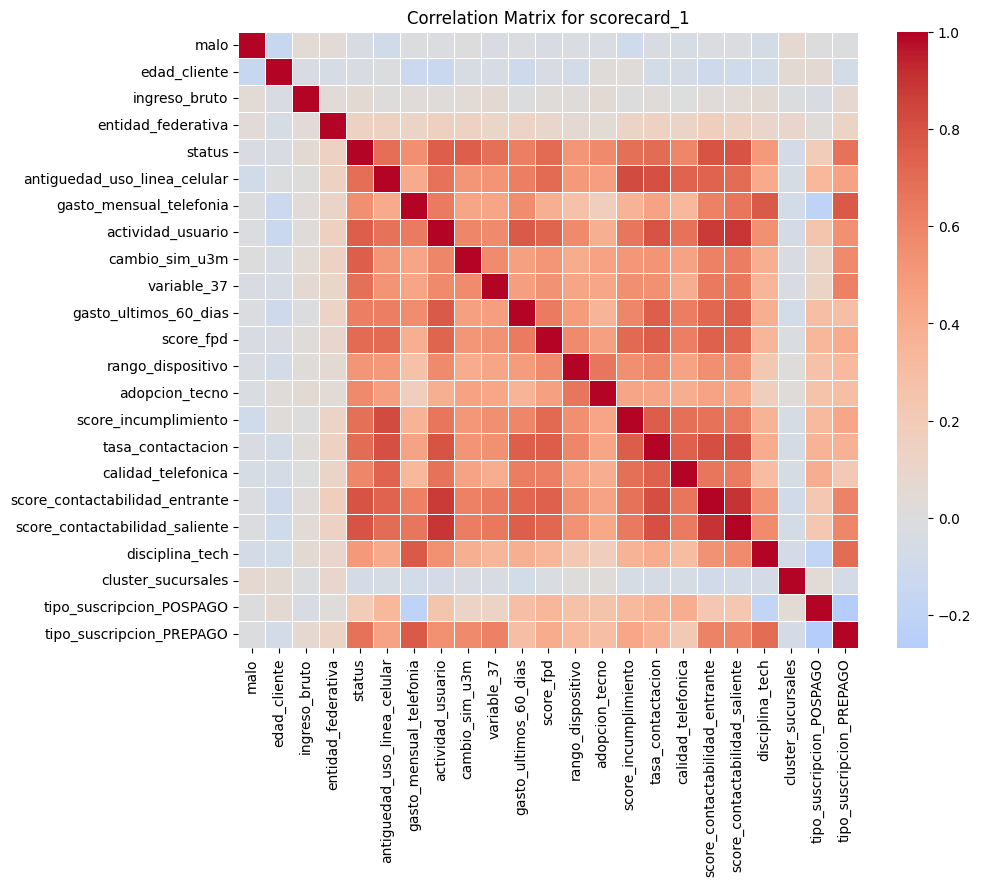


Scorecard scorecard_2 Correlation Matrix


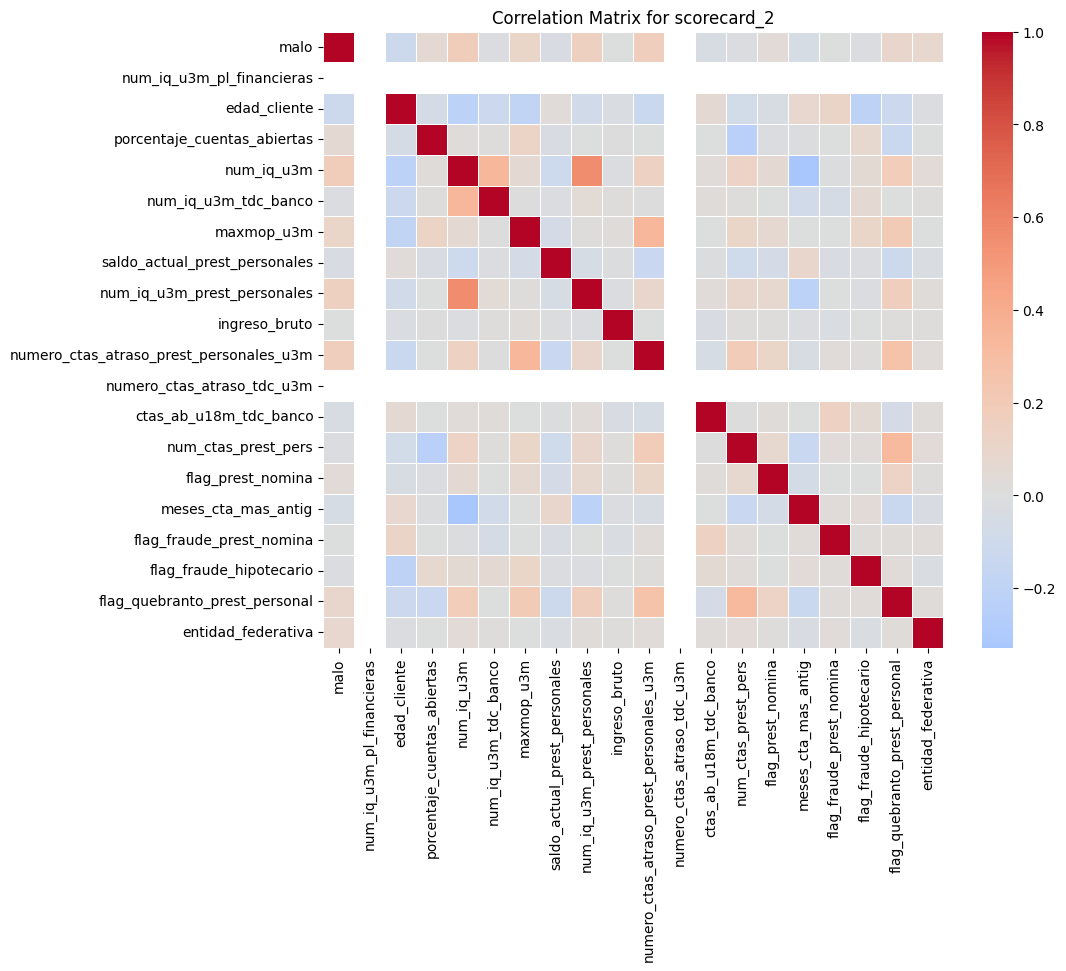


Scorecard scorecard_3 Correlation Matrix


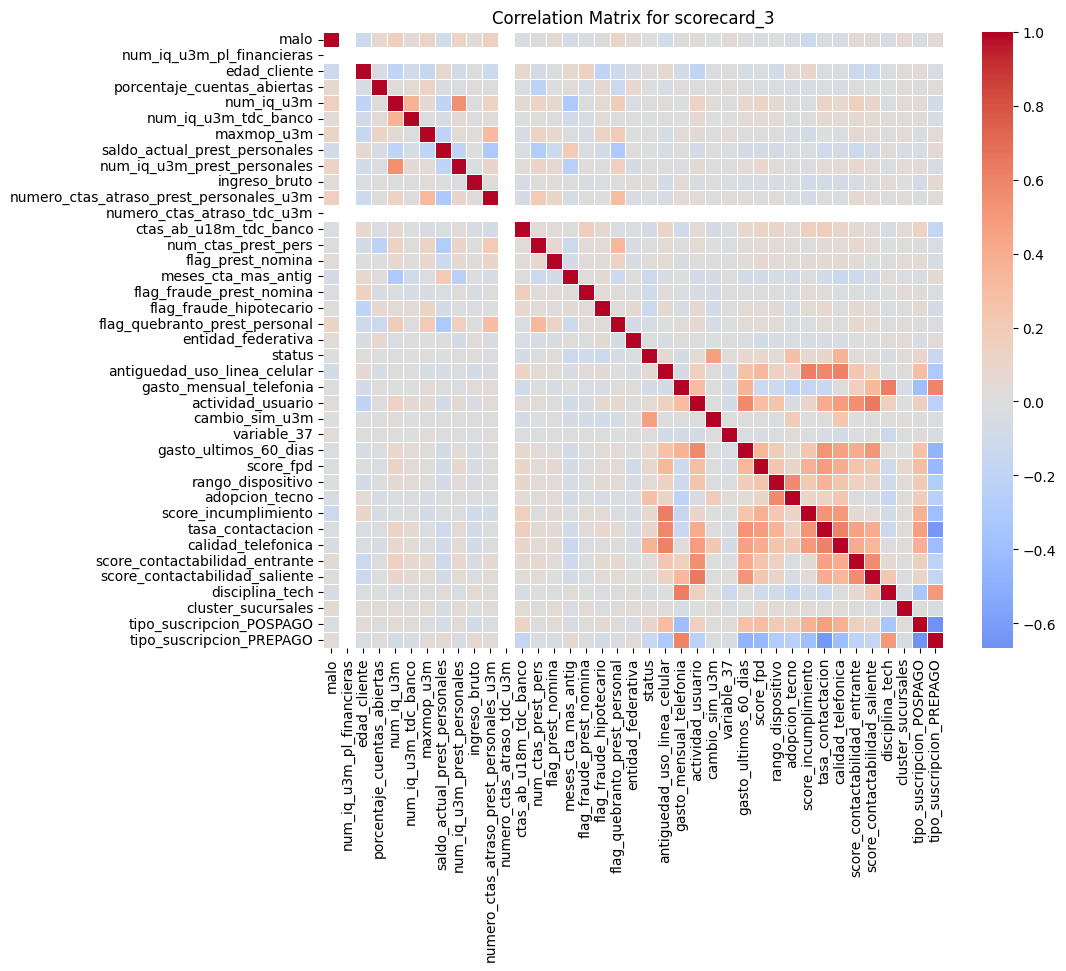

In [13]:
from typing import Dict, List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def feature_selection(iv_ks_results: List[tuple], real_data: Dict[int, pd.DataFrame], corr_threshold: float = 0.6) -> Dict[int, List]:
    result = {}

    for scorecard_num, iv_ks_df in iv_ks_results:
        real_df = real_data[scorecard_num]

        # Calculate the correlation matrix
        corr_matrix = real_df.corr()
        
        # Find pairs of variables with correlation > corr_threshold
        correlated_pairs = [(i, j) for i in range(len(corr_matrix))
                            for j in range(i + 1, len(corr_matrix))
                            if abs(corr_matrix.iloc[i, j]) >= corr_threshold]

        filtered_variables = iv_ks_df.copy().reset_index(drop=True)
        drop_indices = set()

        for i, j in correlated_pairs:
            if i in drop_indices or j in drop_indices:
                continue
            
            if i >= len(filtered_variables) or j >= len(filtered_variables):
                # print(f"Invalid indices: i={i}, j={j} for filtered_variables length: {len(filtered_variables)}")
                continue
            
            var_i = filtered_variables.iloc[i]
            var_j = filtered_variables.iloc[j]

            # print(f"\033[1mCorrelated Variables: {var_i['variable']} and {var_j['variable']}\033[0m")
            if var_i['IV_classification'] == var_j['IV_classification']:
                if var_i['KS'] > var_j['KS']:
                    drop_indices.add(j)
                else:
                    drop_indices.add(i)
            elif var_i['IV_classification'] > var_j['IV_classification']:
                drop_indices.add(j)
            else:
                drop_indices.add(i)

        filtered_variables = filtered_variables.drop(list(drop_indices)).reset_index(drop=True)
        result[scorecard_num] = filtered_variables['variable'].tolist()

    return result

# Example usage of the function
features = feature_selection(iv_ks_results, {
    1: processed_train_dict['scorecard_1'],
    2: processed_train_dict['scorecard_2'],
    3: processed_train_dict['scorecard_3']
})

# Display the selected features for each scorecard
for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mScorecard {scorecard_num} Selected Features\033[0m")
    print(feature_list)

# Define a function to create a correlation matrix
def plot_correlation_matrix(df: pd.DataFrame, threshold: float = 0.6, num=str) -> None:
    """
    This function creates a correlation matrix for the given dataframe and displays it as a heatmap.

    **Parameters**
    df: *DataFrame* Dataframe to create the correlation matrix.
    threshold: *float* [default = 0.6] Threshold for the correlation to be considered high.

    **Returns**
    None
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5,
                xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
    plt.title('Correlation Matrix for ' + str(num))
    plt.show()

# Display the correlation matrix for each scorecard
for scorecard_num, df in processed_train_dict.items():
    print(f"\n\033[1mScorecard {scorecard_num} Correlation Matrix\033[0m")
    plot_correlation_matrix(df, num = scorecard_num)


### Decision Trees No bins


Entrenando modelo para Scorecard 1

Tabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:
+----+----------------------+-------------------+--------------------------+-------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   param_min_samples_leaf | param_criterion   |   mean_test_score |
|----+----------------------+-------------------+--------------------------+-------------------+-------------------|
|  4 |                  100 |                 6 |                       86 | gini              |          0.395177 |
|  7 |                  100 |                 8 |                       86 | gini              |          0.395177 |
| 10 |                  100 |                10 |                       86 | gini              |          0.395177 |
|  5 |                  200 |                 6 |                       86 | gini              |          0.394907 |
|  8 |                  200 |               

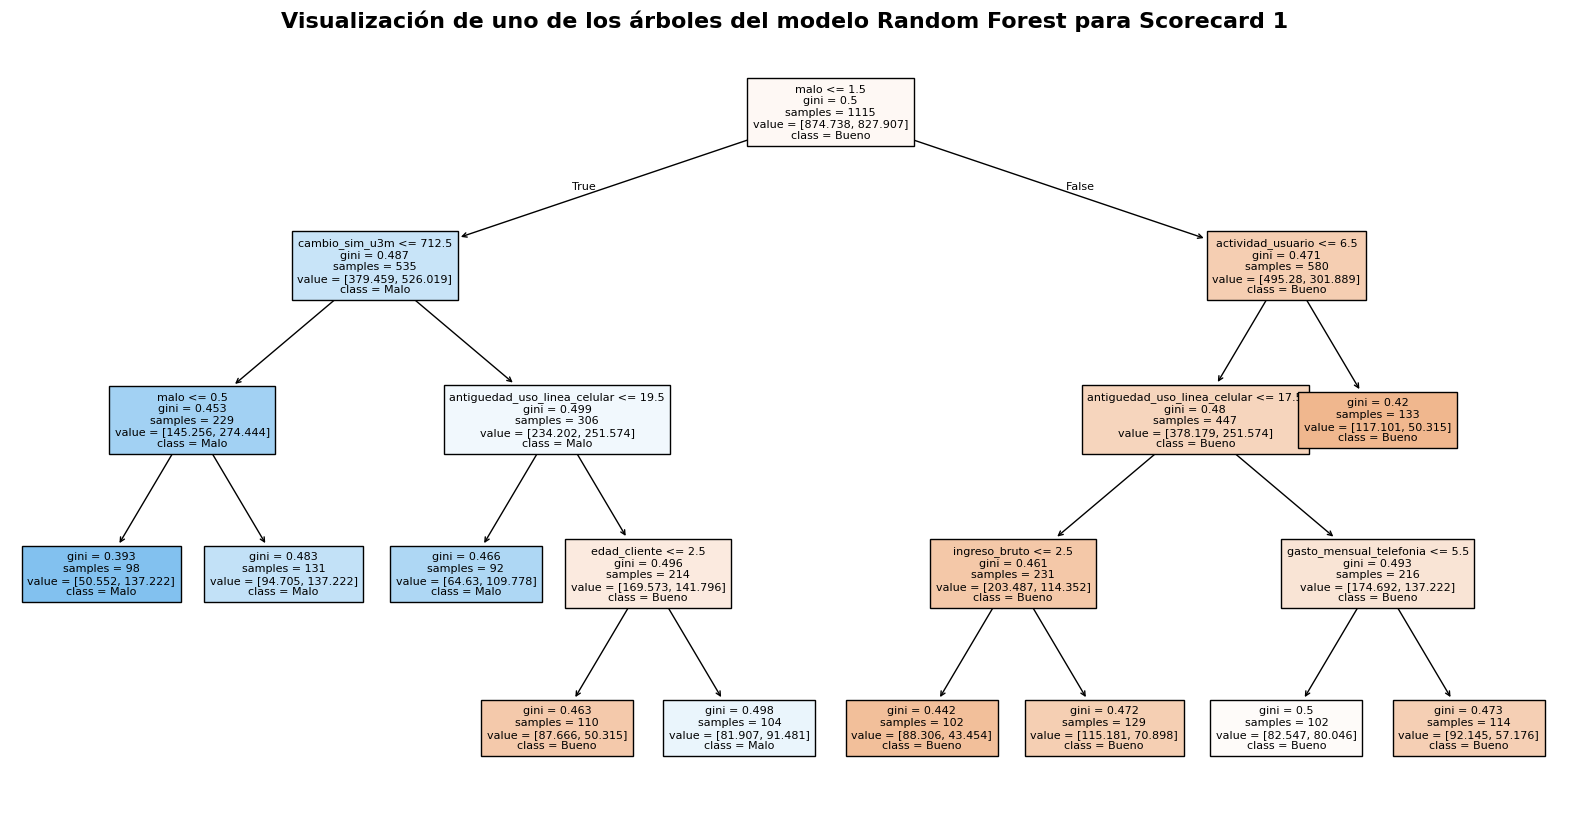


Entrenando modelo para Scorecard 2

Tabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:
+----+----------------------+-------------------+--------------------------+-------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   param_min_samples_leaf | param_criterion   |   mean_test_score |
|----+----------------------+-------------------+--------------------------+-------------------+-------------------|
|  4 |                  100 |                 6 |                      208 | gini              |          0.431067 |
|  7 |                  100 |                 8 |                      208 | gini              |          0.431067 |
| 10 |                  100 |                10 |                      208 | gini              |          0.431067 |
|  1 |                  100 |                 4 |                      208 | gini              |          0.427792 |
|  5 |                  200 |               

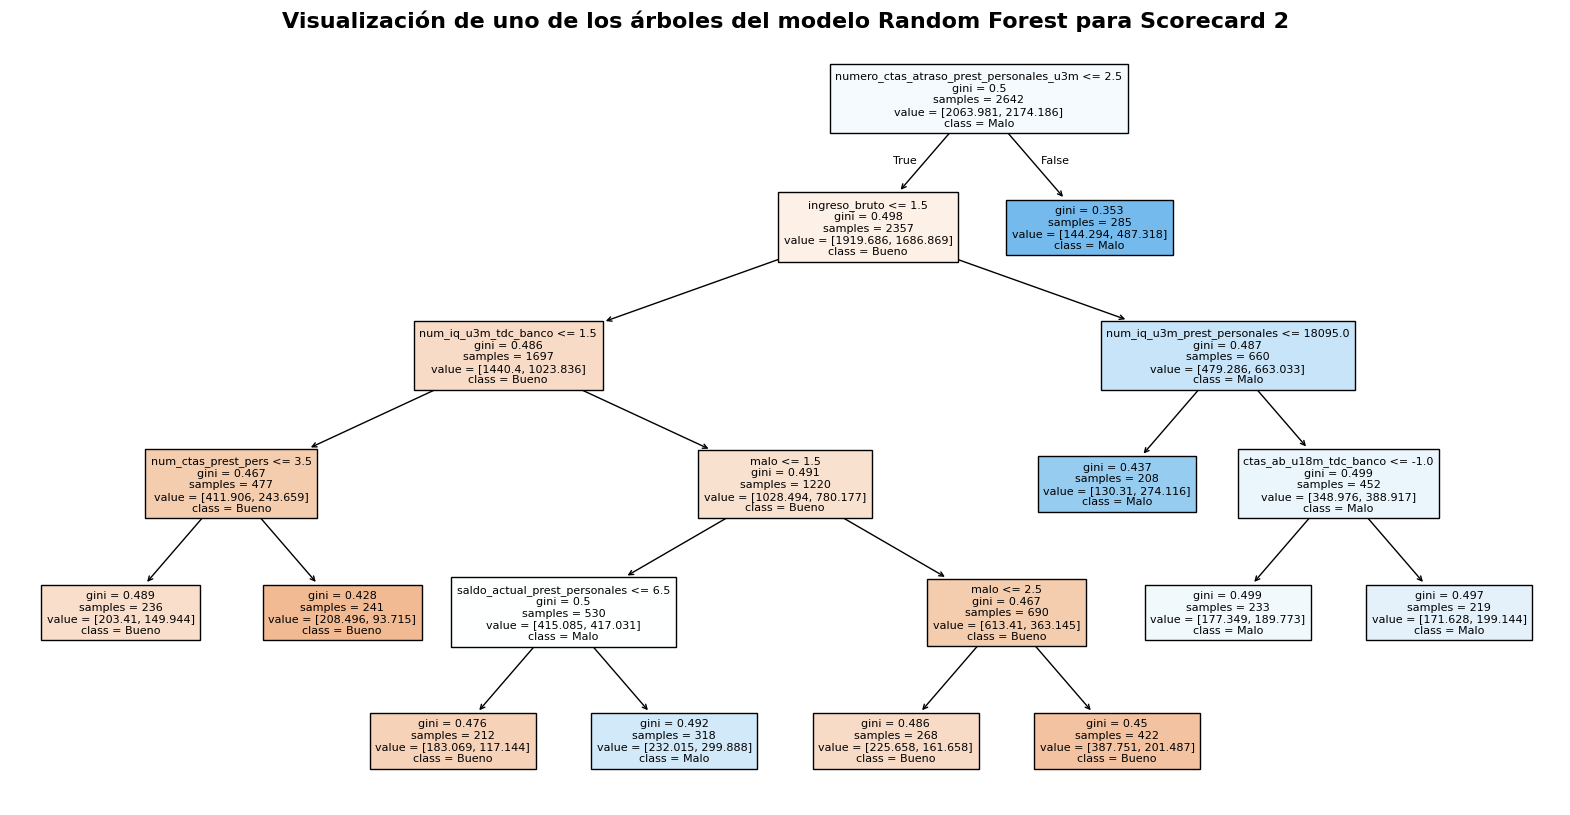


Entrenando modelo para Scorecard 3

Tabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:
+----+----------------------+-------------------+--------------------------+-------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   param_min_samples_leaf | param_criterion   |   mean_test_score |
|----+----------------------+-------------------+--------------------------+-------------------+-------------------|
|  0 |                   50 |                 4 |                      476 | gini              |          0.387076 |
|  3 |                   50 |                 6 |                      476 | gini              |          0.386717 |
|  6 |                   50 |                 8 |                      476 | gini              |          0.386717 |
|  9 |                   50 |                10 |                      476 | gini              |          0.386717 |
|  5 |                  200 |               

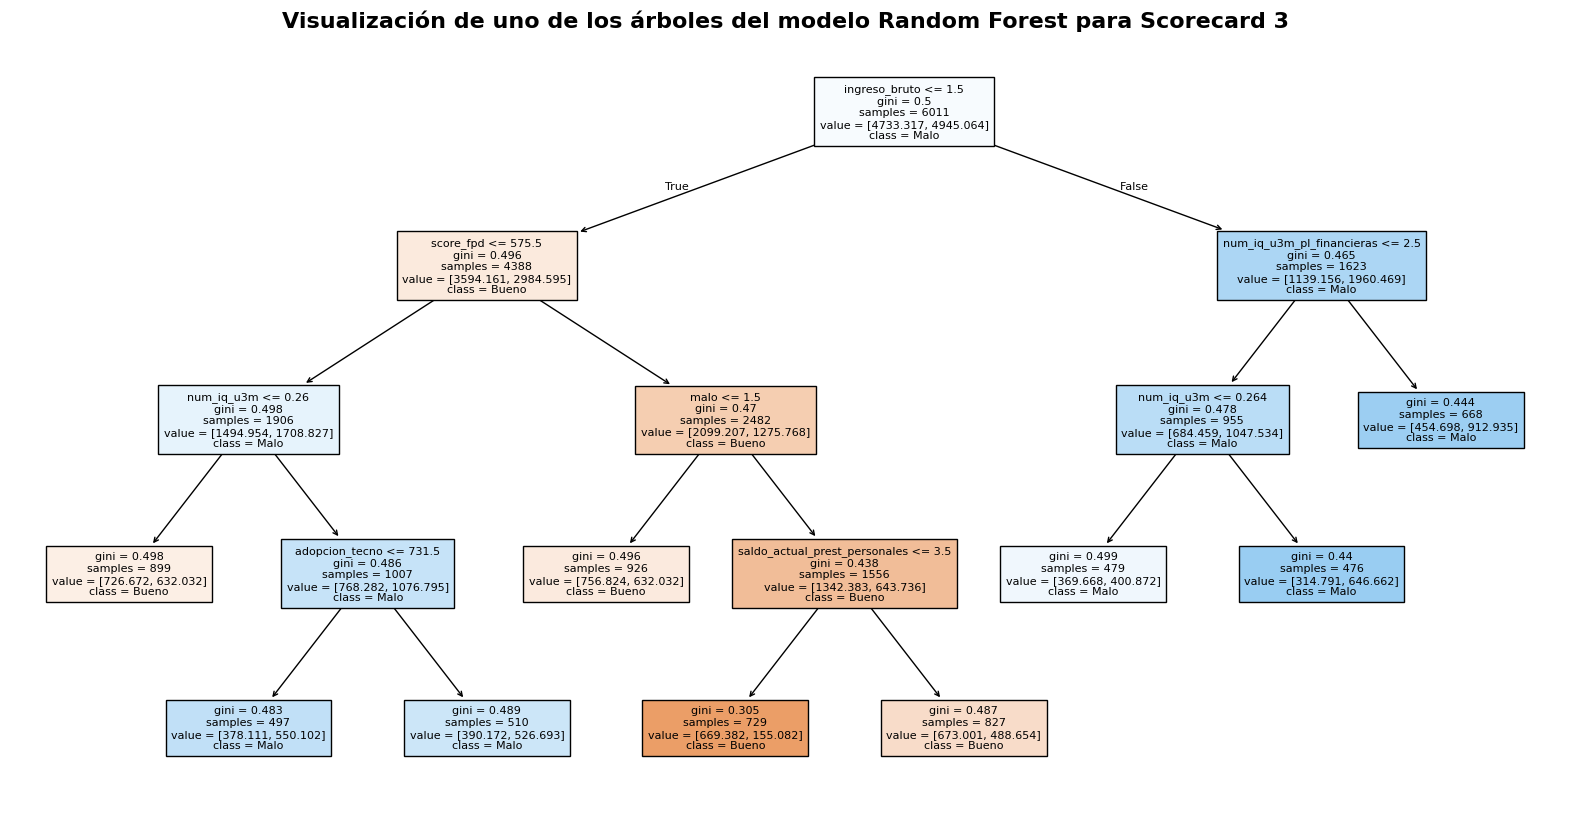

In [14]:
def train_random_forest(df, features, target, scorecard_num):
    # Definir las características (features) y la variable objetivo (y)
    X_train = df[features]  # Seleccionar las columnas de características
    y_train = df[target]    # La variable objetivo es 'target'

    # Definir el valor mínimo de la hoja como el entero del 5% de la población de entrenamiento
    min_samples_leaf = int(0.05 * len(X_train))

    # Definir el clasificador Random Forest con la semilla fija
    random_forest = RandomForestClassifier(random_state=123, class_weight='balanced')

    # Definir los hiperparámetros para la búsqueda
    param_grid = {
        'n_estimators': [50, 100, 200],  # Número de árboles
        'max_depth': [4, 6, 8, 10],  # Profundidades a probar
        'min_samples_leaf': [min_samples_leaf],  # Valor mínimo fijo de la hoja
        'criterion': ['gini'],  # Criterio de evaluación
    }

    # Definir el scorer basado en f1-score o recall para maximizar el poder de discriminación
    scorer = make_scorer(f1_score, pos_label=1)

    # Definir la búsqueda en cuadrícula (GridSearchCV) con validación cruzada
    grid_search_rf = GridSearchCV(random_forest, param_grid, cv=5, scoring=scorer, return_train_score=True)

    # Entrenar el modelo con la búsqueda de hiperparámetros
    grid_search_rf.fit(X_train, y_train)

    # Obtener los resultados en un DataFrame
    results_rf = pd.DataFrame(grid_search_rf.cv_results_)

    # Seleccionar las columnas relevantes para el resumen
    results_summary_rf = results_rf[['param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_criterion', 'mean_test_score']]

    # Ordenar por la métrica de f1-score en el conjunto de prueba
    results_summary_rf = results_summary_rf.sort_values(by='mean_test_score', ascending=False)

    # Mostrar la tabla resumen con las combinaciones de hiperparámetros y el f1-score
    print("\nTabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:")
    print(tabulate(results_summary_rf, headers='keys', tablefmt='psql'))

    # Entrenar el modelo Random Forest con los mejores hiperparámetros encontrados previamente
    best_rf_model = RandomForestClassifier(
        n_estimators=grid_search_rf.best_params_['n_estimators'],
        max_depth=grid_search_rf.best_params_['max_depth'],
        min_samples_leaf=min_samples_leaf,  # Se ajusta al 5% de la población de entrenamiento
        criterion='gini',
        class_weight='balanced',
        random_state=123
    )

    # Entrenar el modelo en los datos de entrenamiento
    best_rf_model.fit(X_train, y_train)

    # Graficar uno de los árboles del Random Forest (para visualizarlo)
    plt.figure(figsize=(20, 10))  # Ajustar el tamaño del gráfico
    plot_tree(best_rf_model.estimators_[0], filled=True, feature_names=x_train.columns, class_names=['Bueno', 'Malo'], fontsize=8)
    plt.title("Visualización de uno de los árboles del modelo Random Forest para Scorecard " + str(scorecard_num), fontsize=16, fontweight='bold')
    plt.show()

    return best_rf_model, results_summary_rf

# Iterate through each scorecard and train a Random Forest model
best_models = {}
results_summaries = {}

# Best models without bins
for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mEntrenando modelo para Scorecard {scorecard_num}\033[0m")
    
    # Get the processed dataset for the current scorecard
    x_train = x_train_dict[f'scorecard_{scorecard_num}']
    
    # Train the Random Forest model for the current scorecard
    best_model, results_summary = train_random_forest(x_train, feature_list, 'malo', scorecard_num)
    
    # Store the best model and results summary for each scorecard
    best_models[f'scorecard_{scorecard_num}'] = best_model
    results_summaries[f'scorecard_{scorecard_num}'] = results_summary

#### Confusion matrix

In [ ]:
# Manage Test Data



Evaluando modelo para Scorecard 1


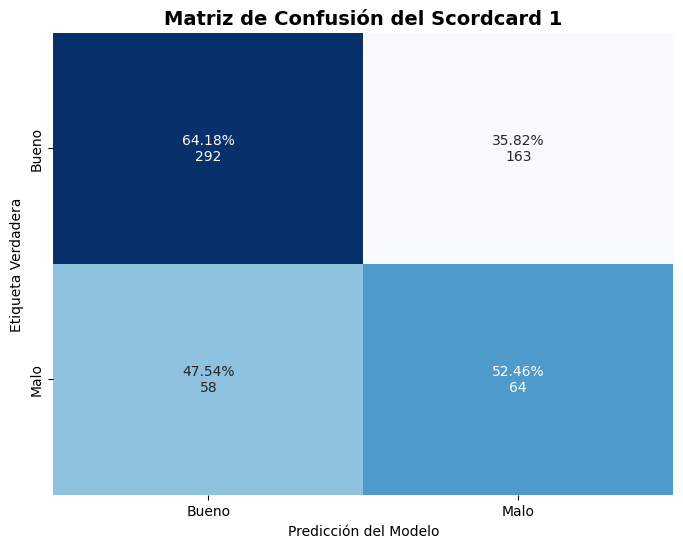

El accuracy del modelo Random Forest en el conjunto de prueba es: 61.70%

Evaluando modelo para Scorecard 2


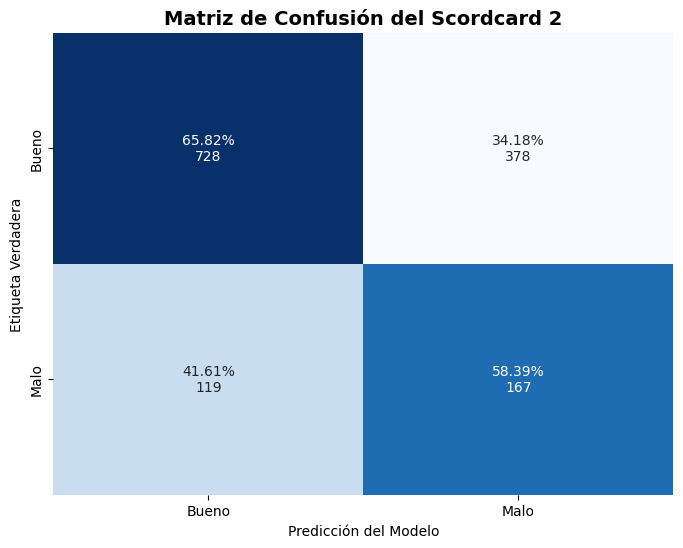

El accuracy del modelo Random Forest en el conjunto de prueba es: 64.30%

Evaluando modelo para Scorecard 3


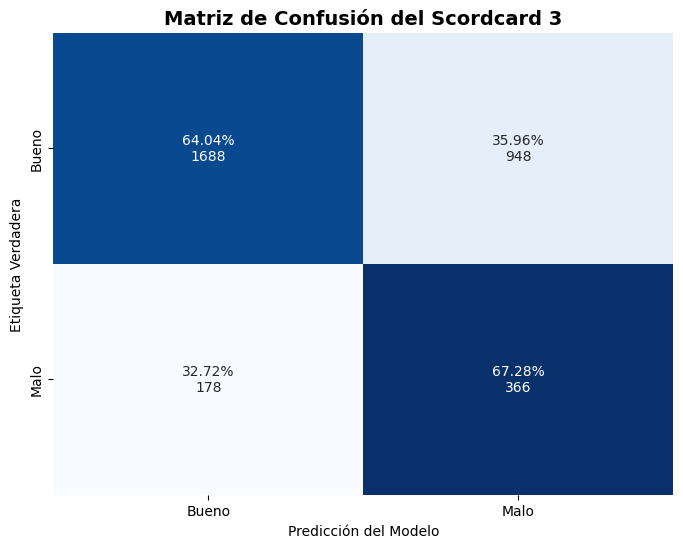

El accuracy del modelo Random Forest en el conjunto de prueba es: 64.59%


In [15]:
def evaluate_model(best_model, X_test, y_test, num):
    # Hacer predicciones con el modelo Random Forest entrenado
    y_pred = best_model.predict(X_test)

    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Calcular los porcentajes por fila (normalizar por fila)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Crear un DataFrame con la matriz de confusión, incluyendo tanto los porcentajes como el número de observaciones
    cm_with_counts = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cm_with_counts[i, j] = f"{cm_percentage[i, j]:.2%}\n{cm[i, j]}"

    # Graficar la matriz de confusión con Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=cm_with_counts, fmt='', cmap='Blues', cbar=False, xticklabels=['Bueno', 'Malo'], yticklabels=['Bueno', 'Malo'])
    plt.title(f"Matriz de Confusión del Scordcard {num}", fontweight='bold', fontsize=14)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción del Modelo')
    plt.show()

    # Calcular el accuracy del modelo en el conjunto de prueba
    accuracy = accuracy_score(y_test, y_pred)

    # Mostrar el resultado
    print(f"El accuracy del modelo Random Forest en el conjunto de prueba es: {accuracy * 100:.2f}%")

for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mEvaluando modelo para Scorecard {scorecard_num}\033[0m")

    X_test = x_test_dict[f'scorecard_{scorecard_num}'][feature_list]
    y_test = y_test_dict[f'scorecard_{scorecard_num}']

    evaluate_model(best_models[f'scorecard_{scorecard_num}'], X_test, y_test, scorecard_num)


### Decisions Tree with bins


Entrenando modelo para Scorecard 1

Tabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:
+----+----------------------+-------------------+--------------------------+-------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   param_min_samples_leaf | param_criterion   |   mean_test_score |
|----+----------------------+-------------------+--------------------------+-------------------+-------------------|
|  4 |                  100 |                 6 |                       86 | gini              |          0.394946 |
|  7 |                  100 |                 8 |                       86 | gini              |          0.394946 |
| 10 |                  100 |                10 |                       86 | gini              |          0.394946 |
|  1 |                  100 |                 4 |                       86 | gini              |          0.39369  |
|  2 |                  200 |               

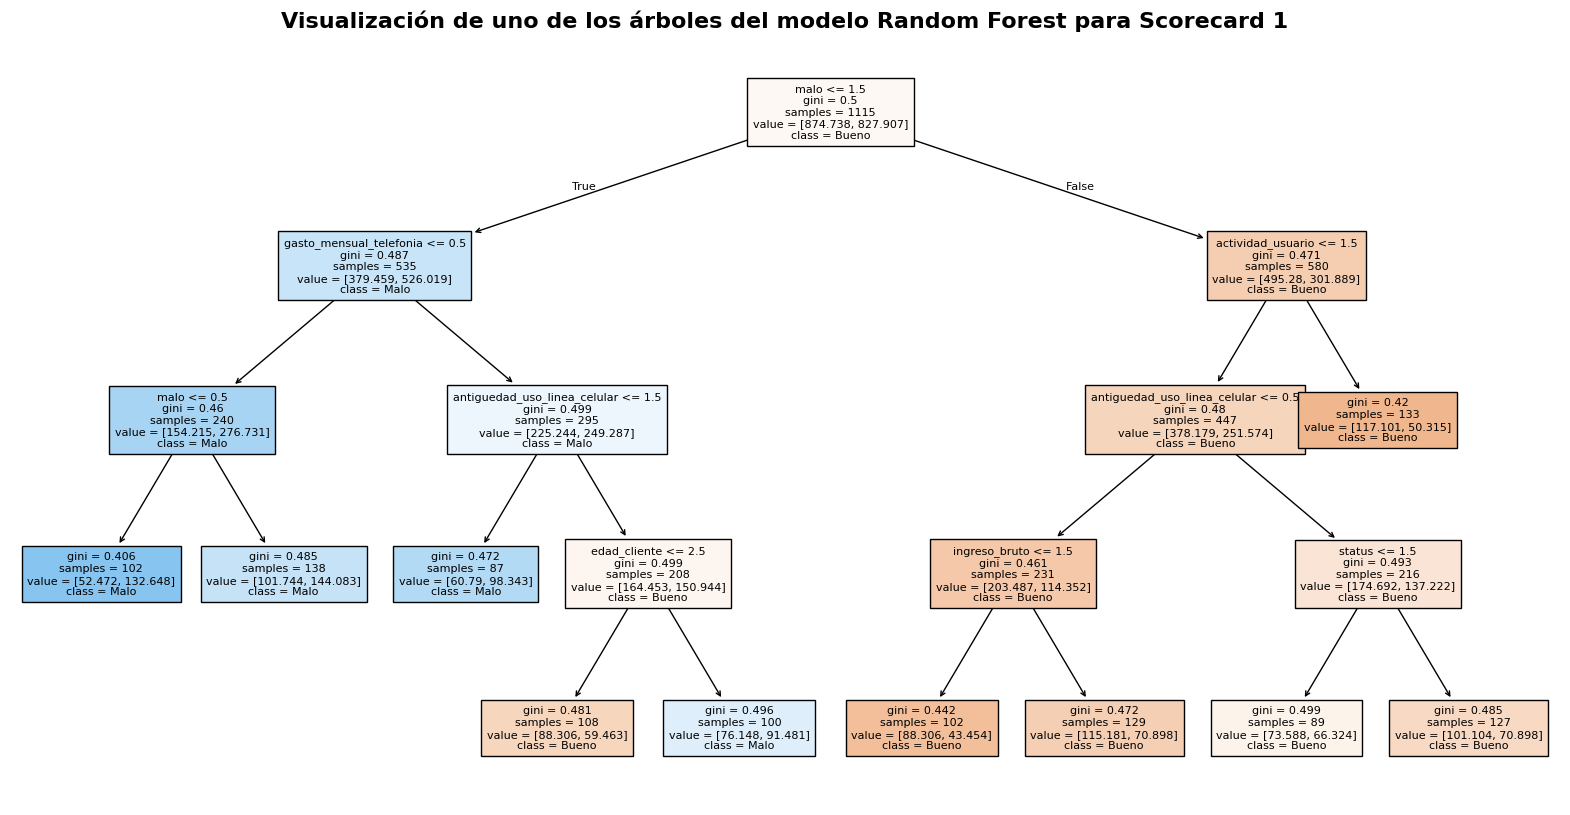


Entrenando modelo para Scorecard 2

Tabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:
+----+----------------------+-------------------+--------------------------+-------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   param_min_samples_leaf | param_criterion   |   mean_test_score |
|----+----------------------+-------------------+--------------------------+-------------------+-------------------|
|  5 |                  200 |                 6 |                      208 | gini              |          0.428116 |
|  2 |                  200 |                 4 |                      208 | gini              |          0.427963 |
|  8 |                  200 |                 8 |                      208 | gini              |          0.427943 |
| 11 |                  200 |                10 |                      208 | gini              |          0.427943 |
|  1 |                  100 |               

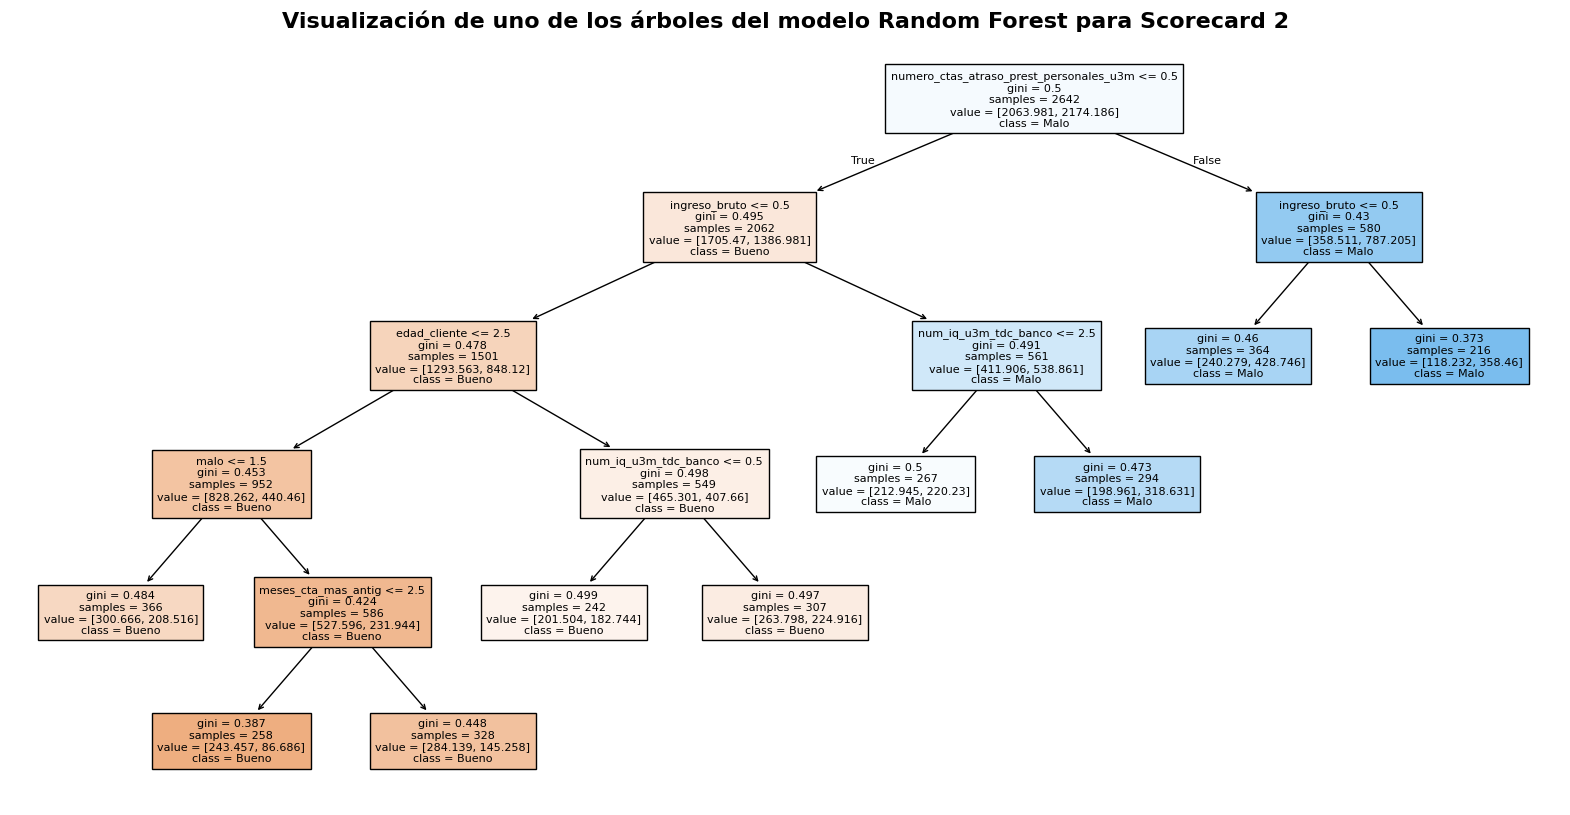


Entrenando modelo para Scorecard 3

Tabla resumen de combinaciones de hiperparámetros y f1-score en Cross Validation con Random Forest:
+----+----------------------+-------------------+--------------------------+-------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   param_min_samples_leaf | param_criterion   |   mean_test_score |
|----+----------------------+-------------------+--------------------------+-------------------+-------------------|
|  5 |                  200 |                 6 |                      476 | gini              |          0.385755 |
|  8 |                  200 |                 8 |                      476 | gini              |          0.385755 |
| 11 |                  200 |                10 |                      476 | gini              |          0.385755 |
|  2 |                  200 |                 4 |                      476 | gini              |          0.383568 |
|  1 |                  100 |               

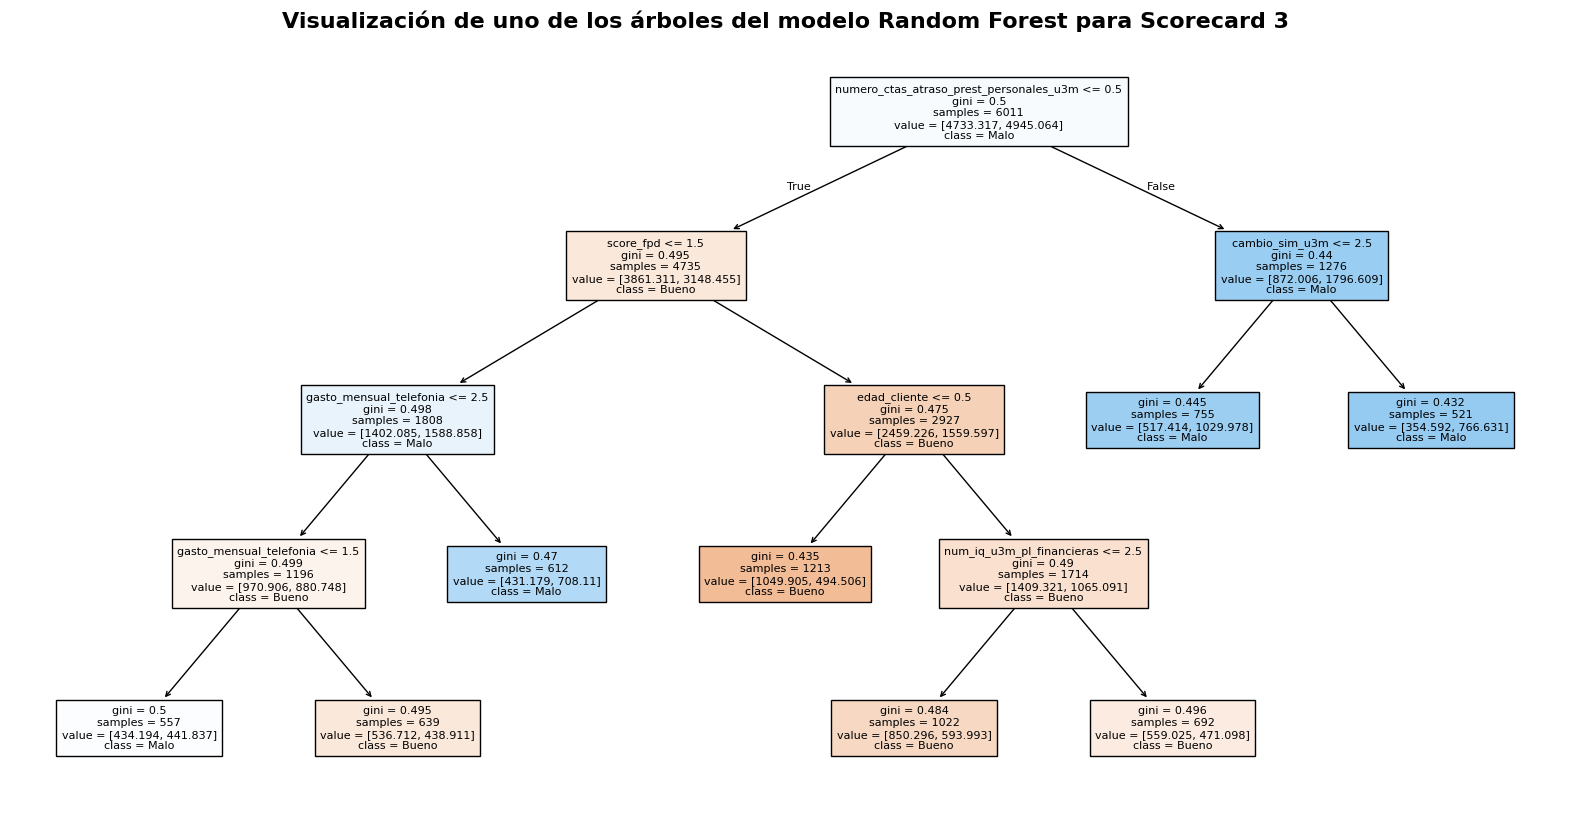

In [16]:
# Iterate through each scorecard and train a Random Forest model
best_models = {}
results_summaries = {}

# best model with bins
for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mEntrenando modelo para Scorecard {scorecard_num}\033[0m")
    
    # Get the processed dataset for the current scorecard
    x_train = processed_train_dict[f'scorecard_{scorecard_num}']
    
    # Train the Random Forest model for the current scorecard
    best_model, results_summary = train_random_forest(x_train, feature_list, 'malo', scorecard_num)
    
    # Store the best model and results summary for each scorecard
    best_models[f'scorecard_{scorecard_num}'] = best_model
    results_summaries[f'scorecard_{scorecard_num}'] = results_summary

#### Confussion Matrix


Evaluando modelo para Scorecard 1


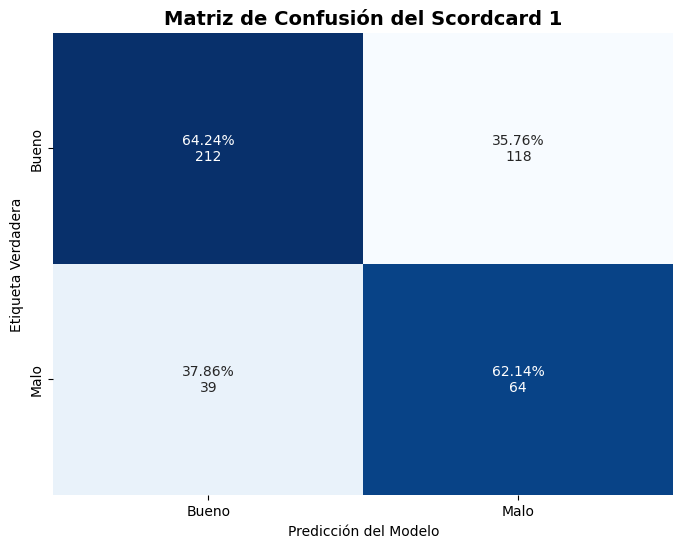

El accuracy del modelo Random Forest en el conjunto de prueba es: 63.74%

Evaluando modelo para Scorecard 2


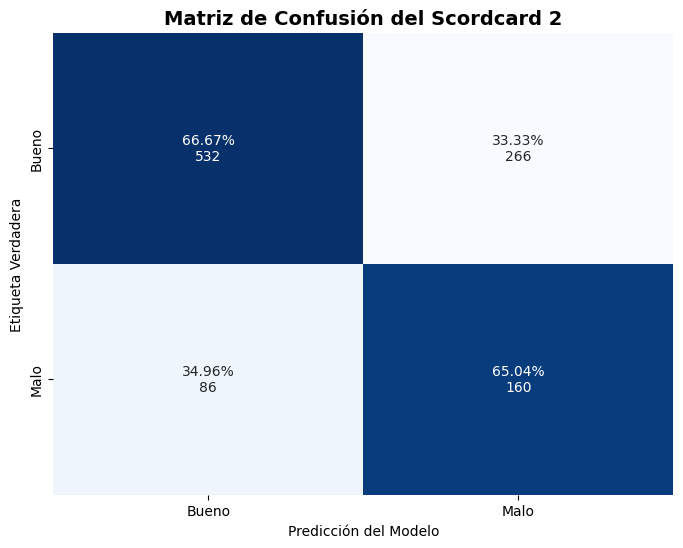

El accuracy del modelo Random Forest en el conjunto de prueba es: 66.28%

Evaluando modelo para Scorecard 3


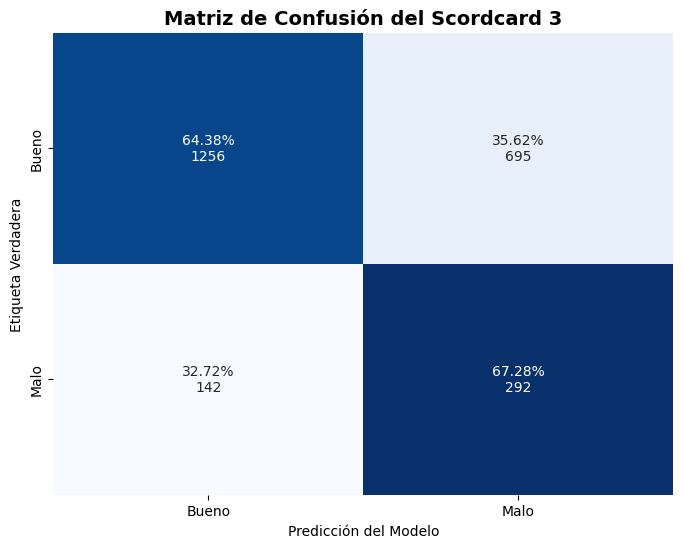

El accuracy del modelo Random Forest en el conjunto de prueba es: 64.91%


In [17]:
for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mEvaluando modelo para Scorecard {scorecard_num}\033[0m")

    x_train = processed_train_dict[f'scorecard_{scorecard_num}']
    X_train, X_test, y_train, y_test = train_test_split(x_train[feature_list], x_train['malo'], test_size=0.25, random_state=123)

    evaluate_model(best_models[f'scorecard_{scorecard_num}'], X_test, y_test, scorecard_num)


### Logistic Regresions

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

def find_optimal_threshold(X_train, X_test, y_train, y_test, model):
    # Fit the model on the scaled training data
    model.fit(X_train, y_train)

    # Get the predicted probabilities for the test data
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    best_threshold = 0.5
    best_diag_min = 0
    best_conf_matrix = None
    
    # Loop to find the optimal threshold
    for threshold in np.arange(0.1, 1.0, 0.01):
        y_pred_custom = (y_pred_prob >= threshold).astype(int)
        conf_matrix = confusion_matrix(y_test, y_pred_custom, normalize='true')
        diag_min = np.min(np.diag(conf_matrix))

        if diag_min >= 0.60 and diag_min > best_diag_min:
            best_threshold = threshold
            best_conf_matrix = conf_matrix
            best_diag_min = diag_min

    return best_threshold, best_conf_matrix

# Example usage for a specific scorecard
for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mFinding optimal threshold for Scorecard {scorecard_num}\033[0m")

    x_train = processed_train_dict[f'scorecard_{scorecard_num}']
    X = x_train[feature_list]
    y = x_train['malo']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the logistic regression model
    logistic_model = LogisticRegression(random_state=123, class_weight='balanced', max_iter=10000, solver='lbfgs')

    # Find the optimal threshold
    best_threshold, best_conf_matrix = find_optimal_threshold(X_train_scaled, X_test_scaled, y_train, y_test, logistic_model)

    print(f"Optimal threshold for Scorecard {scorecard_num}: {best_threshold}")
    print("Confusion Matrix at optimal threshold:\n", best_conf_matrix)
    
    # Optionally save the model for later use
    joblib.dump(logistic_model, f'model_scorecard_{scorecard_num}.pkl')



Finding optimal threshold for Scorecard 1
Optimal threshold for Scorecard 1: 0.4999999999999998
Confusion Matrix at optimal threshold:
 [[0.6        0.4       ]
 [0.37864078 0.62135922]]

Finding optimal threshold for Scorecard 2
Optimal threshold for Scorecard 2: 0.48999999999999977
Confusion Matrix at optimal threshold:
 [[0.6641604  0.3358396 ]
 [0.34552846 0.65447154]]

Finding optimal threshold for Scorecard 3
Optimal threshold for Scorecard 3: 0.48999999999999977
Confusion Matrix at optimal threshold:
 [[0.64582266 0.35417734]
 [0.34792627 0.65207373]]


In [19]:
def apply_optimal_threshold(X_full, scaler, model, threshold):
    # Scale the full dataset
    X_full_scaled = scaler.transform(X_full)

    # Get predicted probabilities
    y_pred_prob_full = model.predict_proba(X_full_scaled)[:, 1]

    # Apply the threshold
    y_pred_optimal = (y_pred_prob_full >= threshold).astype(int)

    return y_pred_optimal

# Example usage for generating confusion matrix with the optimal threshold
for scorecard_num, feature_list in features.items():
    print(f"\n\033[1mEvaluating Scorecard {scorecard_num} with Optimal Threshold\033[0m")

    x_train = processed_train_dict[f'scorecard_{scorecard_num}']
    X_full = x_train[feature_list]
    y_full = x_train['malo']

    # Load the saved model
    model = joblib.load(f'model_scorecard_{scorecard_num}.pkl')

    # Align the feature names of X_full with the expected features used during training
    expected_features = scaler.feature_names_in_  # Get the feature names used during training

    # Reorder and align X_full to match the training features
    X_full_aligned = X_full.reindex(columns=expected_features, fill_value=0)  # Handle missing features

    # Scale the full data using the scaler used during training
    X_full_scaled = scaler.transform(X_full_aligned)

    # Apply the optimal threshold to make predictions
    y_pred_optimal = apply_optimal_threshold(X_full_scaled, model, best_threshold)

    # Calculate and display the confusion matrix
    conf_matrix_final = confusion_matrix(y_full, y_pred_optimal)
    print("Final Confusion Matrix:\n", conf_matrix_final)

    # Optionally, plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_final, annot=True, cmap='Blues', fmt="d", cbar=False)
    plt.title(f"Confusion Matrix for Scorecard {scorecard_num}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



Evaluating Scorecard 1 with Optimal Threshold


TypeError: apply_optimal_threshold() missing 1 required positional argument: 'threshold'

In [ ]:
# Asumiendo que 'x_train_bins' es tu dataset principal
X = x_train_bins[features]  # Seleccionar las columnas de características
y = x_train_bins['malo']  # La variable objetivo es 'malo'

# Dividir los datos en conjunto de entrenamiento (75%) y prueba (25%) con una semilla fija para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Escalar los datos para mejorar la convergencia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo de regresión logística con mayor número de iteraciones y balance de clases
logistic_regression = LogisticRegression(random_state=123, class_weight='balanced', max_iter=10000, solver='lbfgs')

# Entrenar el modelo de regresión logística con los datos de entrenamiento escalados
logistic_regression.fit(X_train_scaled, y_train)

# Hacer predicciones con el modelo en los datos de prueba escalados
y_pred_logistic = logistic_regression.predict(X_test_scaled)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
print("Matriz de Confusión:")
print(conf_matrix)

# Generar un reporte de clasificación detallado
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_logistic))

# Calcular el accuracy del modelo de regresión logística
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"El accuracy del modelo de Regresión Logística en el conjunto de prueba es: {accuracy_logistic * 100:.2f}%")

# Mostrar los coeficientes del modelo
print("Coeficientes del modelo:")
for feature, coef in zip(features, logistic_regression.coef_[0]):
    print(f"{feature}: {coef}")

# Guardar el modelo entrenado para su uso futuro
joblib.dump(logistic_regression, 'modelo_credit_scoring_logistic.pkl')
print("Modelo guardado exitosamente.")

# Guardar los resultados de predicción en un archivo CSV para análisis posterior
y_pred_probabilities = logistic_regression.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de clase '1' (mal pagador)
resultados = pd.DataFrame({'Predicción': y_pred_logistic, 'Probabilidad_Mal_Pagador': y_pred_probabilities})
resultados.to_csv('resultados_probabilidades_logistic.csv', index=False)
print("Predicciones completadas y guardadas en 'resultados_probabilidades_logistic.csv'.")

#### Confussion Matrix

In [ ]:
# Definir una función para verificar si la diagonal principal cumple con el criterio >= 60%
def check_diagonal_60(cm):
    bueno_bueno = cm[0, 0] / cm[0].sum()  # Bueno (Verdadero) y Bueno (Predicho)
    malo_malo = cm[1, 1] / cm[1].sum()    # Malo (Verdadero) y Malo (Predicho)
    return bueno_bueno >= 0.60 and malo_malo >= 0.60

# Definir el modelo de regresión logística
logistic_regression = LogisticRegression(random_state=123, class_weight='balanced', max_iter=5000)

# Definir los hiperparámetros para la búsqueda
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Controla la regularización
    'solver': ['lbfgs', 'liblinear'],  # Solvers a probar
}

# Definir la búsqueda en cuadrícula con validación cruzada
grid_search_logistic = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search_logistic.fit(X_train_scaled, y_train)

# Obtener el mejor modelo encontrado
best_logistic_model = grid_search_logistic.best_estimator_

# Probar diferentes umbrales de decisión para encontrar uno que satisfaga el criterio >=60%
optimal_threshold = 0.5
y_pred_proba = best_logistic_model.predict_proba(X_test_scaled)[:, 1]  # Predicciones probabilísticas

for threshold in np.arange(0.3, 0.7, 0.01):  # Probar desde 0.3 a 0.7 con saltos de 0.01
    # Ajustar el umbral de decisión
    y_pred_logistic_tuned = np.where(y_pred_proba >= threshold, 1, 0)

    # Generar la matriz de confusión
    cm_logistic_tuned = confusion_matrix(y_test, y_pred_logistic_tuned)

    # Verificar si la diagonal principal cumple con el criterio >=60%
    if check_diagonal_60(cm_logistic_tuned):
        optimal_threshold = threshold
        break

# Calcular la matriz de confusión final con el umbral óptimo
y_pred_final = np.where(y_pred_proba >= optimal_threshold, 1, 0)
cm_final = confusion_matrix(y_test, y_pred_final)

# Calcular los porcentajes por fila (normalizar por fila)
cm_percentage_final = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]

# Crear un DataFrame con la matriz de confusión final
cm_with_counts_final = pd.DataFrame(index=['Bueno (Verdadero)', 'Malo (Verdadero)'],
                                    columns=['Bueno (Predicho)', 'Malo (Predicho)'])

# Rellenar la matriz con porcentajes y números de observaciones
for i in range(cm_final.shape[0]):
    for j in range(cm_final.shape[1]):
        cm_with_counts_final.iloc[i, j] = f"{cm_percentage_final[i, j]:.2%} ({cm_final[i, j]})"

# Mostrar la matriz de confusión final
print("\nMatriz de Confusión final ajustada con umbral óptimo:")
print(cm_with_counts_final)

# Mostrar el umbral óptimo encontrado y los mejores hiperparámetros
print(f"\nUmbral óptimo encontrado: {optimal_threshold}")
print(f"Mejores hiperparámetros encontrados: {grid_search_logistic.best_params_}")

In [ ]:
# Asumiendo que 'x_train_bins' es tu dataset principal
X = x_train[features]  # Seleccionar las columnas de características
y = x_train['malo']  # La variable objetivo es 'malo'

# Dividir los datos en conjunto de entrenamiento (75%) y prueba (25%) con una semilla fija para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Escalar los datos para mejorar la convergencia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo de regresión logística con un mayor número de iteraciones
logistic_model = LogisticRegression(random_state=123, class_weight='balanced', max_iter=10000, solver='lbfgs')

# Entrenar el modelo de regresión logística con los datos de entrenamiento escalados
logistic_model.fit(X_train_scaled, y_train)

# Función para calcular la matriz de confusión con un umbral personalizado
def evaluate_threshold(threshold):
    # Obtener las probabilidades predichas
    y_pred_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]
    # Convertir las probabilidades a predicciones utilizando el umbral
    y_pred_custom = (y_pred_prob >= threshold).astype(int)
    # Calcular la matriz de confusión normalizada
    conf_matrix = confusion_matrix(y_test, y_pred_custom, normalize='true')
    return conf_matrix

# Inicializar el mejor umbral
best_threshold = 0.47000000000000014
best_conf_matrix = evaluate_threshold(best_threshold)
best_diag_min = np.min(np.diag(best_conf_matrix))

# Probar varios umbrales para encontrar el que maximice los valores de la diagonal principal
for threshold in np.arange(0.1, 1.0, 0.01):
    conf_matrix = evaluate_threshold(threshold)
    diag_min = np.min(np.diag(conf_matrix))

    # Si ambos valores en la diagonal son al menos 0.60, actualizar el mejor umbral
    if diag_min >= 0.60 and diag_min > best_diag_min:
        best_threshold = threshold
        best_conf_matrix = conf_matrix
        best_diag_min = diag_min

# Mostrar el umbral óptimo y la matriz de confusión correspondiente
print(f"Umbral óptimo: {best_threshold}")
print("Matriz de Confusión optimizada:\n", best_conf_matrix)

# Generar el mapa de calor de la matriz de confusión optimizada
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_matrix, annot=True, cmap='Blues', fmt=".2%", cbar=False)
plt.title(f"Matriz de Confusión Normalizada (Umbral: {best_threshold})")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Guardar el modelo entrenado para su uso futuro
joblib.dump(logistic_model, 'modelo_credit_scoring_umbral_personalizado.pkl')
print("Modelo guardado exitosamente con el umbral personalizado.")

In [ ]:
# Utilizar el umbral óptimo encontrado anteriormente
optimal_threshold = best_threshold

X_full = x_train[features]

# Escalar los datos de 'X_full' usando el mismo scaler ajustado previamente (scaler)
X_full_scaled = scaler.transform(X_full)

# Obtener las probabilidades predichas para 'X_full' escalado
y_pred_prob_full = logistic_model.predict_proba(X_full_scaled)[:, 1]

# Aplicar el umbral óptimo para generar predicciones binarias
y_pred_optimal = (y_pred_prob_full >= optimal_threshold).astype(int)

# Añadir la probabilidad estimada y la predicción óptima al DataFrame x_train_clean
x_train['Prob'] = y_pred_prob_full  # Etiqueta más corta: 'Prob'
x_train['Pred'] = y_pred_optimal  # Etiqueta más corta: 'Pred'

# Mostrar las primeras filas del DataFrame actualizado
x_train.head()

In [ ]:
target_names = ['0-Bueno', '1-Malo']

# Imprimir el reporte de clasificación con los nombres de las clases
print(classification_report(y_test, y_pred, target_names=target_names))